In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget 

import sys, os

import matplotlib.style as style

import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

import scqubits as scq
import qutip as qt
import qutip.visualization as qplt
import scipy as sp

from PulseSequence import PulseSequence
from QSwitch import QSwitch

style.use('default')
plt.rcParams['figure.figsize'] = [9.7, 6]
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# scq.settings.PROGRESSBAR_DISABLED = True

In [2]:
hbar = 1.054e-34
h = hbar*2*np.pi
qe = 1.602e-19
red_flux_quant = hbar/2/qe 

# Unit conversions
MHz = 10.0**(-3)
GHz = 1.0
kHz = 10.0**(-6)
us = 10.0**3
ns = 1.0

Plotting functions

In [3]:
def get_tomo_labels(num_tomo):
    if num_tomo == 1:
        calib_order = ['g', 'e']
    elif num_tomo == 2:
        calib_order = ['gg', 'ge', 'eg', 'ee']
    elif num_tomo == 3:
        calib_order = ['ggg', 'gge', 'geg', 'gee', 'egg', 'ege', 'eeg', 'eee']
    else: assert False, 'no calib order defined'
    calib_order_numeric = np.zeros_like(calib_order)
    for i, label in enumerate(calib_order):
        label_numeric = ''
        for char in label:
            if char == 'g': label_numeric += '0'
            elif char == 'e': label_numeric += '1'
        calib_order_numeric[i] = label_numeric
    return calib_order_numeric

from mpl_toolkits.axes_grid1 import make_axes_locatable
def show_mat_2d(mat, ax, title, labels, cmax=1, show=True):
    """
    Plot an arbitrary 2D matrix with labels
    """
    plt.sca(ax)
    plt.title(title, fontsize=18)
    plt.imshow(np.real(mat), cmap='RdBu')
    # hinton(np.real(mat), xlabels=labels, ylabels=labels)
    plt.xticks(np.arange(len(mat)), labels, fontsize=14, rotation=45)
    plt.yticks(np.arange(len(mat)), labels, fontsize=14)
    # Loop over data dimensions and create text annotations.
    for ii in range(len(mat)):
        for jj in range(len(mat)):
            plt.text(ii, jj, round(mat[jj, ii], 3), ha="center", va="center", color="w", size=11, rotation=45)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(cax=cax, ticks=[-cmax, 0, cmax])
    cbar.ax.tick_params(labelsize=14)
    plt.clim(vmin=-cmax, vmax=cmax)
    if show:
        plt.tight_layout()
        plt.show()

def show_plot_rho_2d(rho_MLE, rho_id=None, num_tomo=None, title=None, cmax=None, savetitle=None):
    """
    Plot real and imag parts of rho, optionally also with a comparison ideal rho
    """
    if savetitle is not None: plt.style.use('dark_background')

    assert num_tomo is not None
    labels = get_tomo_labels(num_tomo=num_tomo)

    if rho_id is None:
        fig = plt.figure(figsize=(10, 5))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)
    else:
        fig = plt.figure(figsize=(10, 9))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(223)
        ax4 = fig.add_subplot(224)
    plt.suptitle(title, fontsize=18)
    if cmax is None: cmax = np.max(np.abs(np.array([np.real(rho_MLE), np.imag(rho_MLE), np.real(rho_id), np.imag(rho_id)])))
    show_mat_2d(np.real(rho_MLE), ax=ax1, title="Re[$\\rho_{test}$]", labels=labels, cmax=cmax, show=False)
    show_mat_2d(np.imag(rho_MLE), ax=ax2, title="Im[$\\rho_{test}$]", labels=labels, cmax=cmax, show=False)
    show_mat_2d(np.real(rho_id), ax=ax3, title="Re[$\\rho_{Ideal}$]", labels=labels, cmax=cmax, show=False)
    show_mat_2d(np.imag(rho_id), ax=ax4, title="Im[$\\rho_{Ideal}$]", labels=labels, cmax=cmax, show=False)
    plt.tight_layout()

    if savetitle is not None:
        plt.savefig(savetitle, format='png', bbox_inches='tight', transparent = True)
    plt.show()

def show_plot_rho_3d(rho_sim, rho_id=None, title='', zmin=None, zmax=None, width=0.75, elev=30, azim=-20, savetitle=None):
    if savetitle is not None: plt.style.use('dark_background')
    fig = plt.figure(figsize=(15, 7))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')
    
    labels = ["00", "01", "10", "11"]
    _xx, _yy = np.meshgrid(np.arange(4), np.arange(4))
    x, y = _xx.ravel(), _yy.ravel()
    if zmax is None: zmax = np.max(np.array([np.real(rho_sim), np.imag(rho_sim), np.real(rho_id), np.imag(rho_id)]))
    if zmin is None: zmin = np.min((0, np.min(np.array([np.real(rho_sim), np.imag(rho_sim), np.real(rho_id), np.imag(rho_id)]))))

    ax1.view_init(elev=elev, azim=azim)
    ax1.set_xticks(np.arange(4), minor=False)
    ax1.set_xticklabels(labels, fontdict=None, minor=False, fontsize=16)
    ax1.set_yticks(np.arange(1, 5, 1), minor=False)
    ax1.set_yticklabels(labels, fontdict=None, minor=False, fontsize=16)
    for t in ax1.zaxis.get_major_ticks(): t.label.set_fontsize(16)
    ax1.bar3d(x, y, z=np.zeros((16)), dx=width, dy=width, dz=np.real(rho_id).flatten(), edgecolor='k', alpha=0)
    ax1.bar3d(x, y, z=np.zeros((16)), dx=0.95*width, dy=width, dz=np.real(rho_sim).flatten(), color='cornflowerblue', edgecolor='mediumblue', alpha=1.0)
    ax1.set_zlim(zmin, zmax)
    ax1.set_title("Re[$\\rho$]", fontsize=20)

    ax2.view_init(elev=elev, azim=azim)
    ax2.set_xticks(np.arange(4), minor=False)
    ax2.set_xticklabels(labels, fontdict=None, minor=False, fontsize=16)
    ax2.set_yticks(np.arange(1, 5, 1), minor=False)
    ax2.set_yticklabels(labels, fontdict=None, minor=False, fontsize=16)
    for t in ax2.zaxis.get_major_ticks(): t.label.set_fontsize(16)
    ax2.bar3d(x, y, z=np.zeros((16)), dx=width, dy=width, dz=np.imag(rho_id).flatten(), edgecolor='k', alpha=0)
    ax2.bar3d(x, y, z=np.zeros((16)), dx=0.95*width, dy=width, dz=np.imag(rho_sim).flatten(), color='cornflowerblue', edgecolor='mediumblue', alpha=1.0)
    ax2.set_zlim(zmin, zmax)
    ax2.set_title("Im[$\\rho$]", fontsize=20)

    plt.suptitle(title, fontsize=22)
    plt.tight_layout()

    if savetitle is not None:
        plt.savefig(savetitle, format='png', bbox_inches='tight', transparent=True)
    plt.show()

# Get couplings and bare frequencies by optimization

In [4]:
sys.path.append(os.getcwd()+'/../../qutip_sims')
from scipy.optimize import minimize
from slab import AttrDict

Could not import QickInstrument (will only work if running on rfsoc). If running on rfsoc, try install/update qick package
Warning failed to import AWG81180A
Warning failed to import Tek5014
Warning failed to import Tek70001
Warning failed to import M8195A


 c:\ProgramData\Anaconda3\lib\site-packages\IPython\qt.py: 12

Could not load InstrumentManagerWindow
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


In [5]:
# gs_arr = [g01, g12, g13, g02, g03, g23]
def gs_mat_from_gs_arr(gs_arr):
    gs_matrix = np.zeros((4,4)) # first dim: qubit 0, second dim: qubit 1
    gs_matrix[0, 1] = gs_arr[0]
    gs_matrix[1, 2] = gs_arr[1]
    gs_matrix[1, 3] = gs_arr[2]
    gs_matrix[0, 2] = gs_arr[3]
    gs_matrix[0, 3] = gs_arr[4]
    gs_matrix[2, 3] = gs_arr[5]
    gs_matrix += gs_matrix.transpose()
    return gs_matrix

In [55]:
# Provide measured qubit freqs (GHz), alphas (GHz), ZZ matrix (GHz)
# For use in optimization
def ZZ_g_fq_alpha_diff(fges_alphas_gs, *args):
    qubit_freqs, alphas_meas, ZZ_matrix = args # measured values
    fges = fges_alphas_gs[:4] 
    alphas = fges_alphas_gs[4:8] 
    gs = fges_alphas_gs[8:]
    # print(args)
    qram = QSwitch(
        EJs=None,
        ECs=None,
        gs=gs_mat_from_gs_arr(gs),
        qubit_freqs=fges,
        alphas=alphas,
        cutoffs=[3, 3, 3, 3],
        isCavity=[False]*4,
    )
    # print(qram.get_ZZ_matrix())
    # return np.sum(np.abs(ZZ_matrix - qram.get_ZZ_matrix()))
    error_ZZ = np.sum(np.abs(1e3*(ZZ_matrix - qram.get_ZZ_matrix()))**2)
    # error_ZZ = np.sum(np.abs(1e3*(abs(ZZ_matrix) - abs(qram.get_ZZ_matrix())))**2)
    error_fge = 0
    error_alpha = 0
    gstate = 'gggg'
    for i in range(4):
        estate = gstate[:i] + 'e' + gstate[i+1:]
        error_fge += np.sum(np.abs(1e3*(qram.get_base_wd(gstate, estate)/2/np.pi - qubit_freqs[i])**2))
        fstate = gstate[:i] + 'f' + gstate[i+1:]
        error_alpha += np.sum(np.abs(1e3*(qram.get_base_wd(estate, fstate)/2/np.pi - (qubit_freqs[i] + alphas_meas[i]))**2))
    return error_ZZ + error_fge + error_alpha

In [48]:
# config_dir = 'C:\\Users\\slab\\Desktop\\Connie\\experiments\\qramLL_4QR2'
config_dir = 'S:\\Connie\\experiments\\qramLL_4QR2'
# config_file = 'config_zcu216.yml'
# config_file = 'config_q3diamond.yml'
# config_file = 'config_q3diamond_full688_reset.yml'
config_file = 'config_q3diamond_full688and638_reset.yml'
config_path = config_dir + '\\' + config_file
print('Config will be', config_path)

Config will be S:\Connie\experiments\qramLL_4QR2\config_q3diamond_full688and638_reset.yml


In [56]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

qubit_freqs_MHz = np.array(yaml_cfg.device.qubit.f_ge) + np.array(yaml_cfg.hw.soc.dacs.qubit.mixer_freq)
ef_freqs_MHz = np.array(yaml_cfg.device.qubit.f_ef)
alphas_MHz = ef_freqs_MHz + np.array(yaml_cfg.hw.soc.dacs.qubit.mixer_freq) - qubit_freqs_MHz
gs_MHz = np.array(yaml_cfg.device.qubit.gs)
ZZshifts_MHz = np.reshape(np.array(yaml_cfg.device.qubit.ZZs), (4,4)) # MHz

print('qubit freqs', qubit_freqs_MHz)
print('ef freqs', ef_freqs_MHz)
print('alphas', alphas_MHz)
print('ZZs', ZZshifts_MHz)

qubit freqs [4113.18459743 3449.2920214  4764.55349377 4382.53193722]
ef freqs [3886.95935741 3349.4891549  4574.69475757 4209.79263024]
alphas [-226.22524003  -99.8028665  -189.8587362  -172.73930698]
ZZs [[ 0.         -5.32940685 -0.1440266  -0.56772412]
 [-5.31516681  0.         -1.09548942 -1.29001269]
 [-0.15001505 -1.09860773  0.         -0.51867797]
 [-0.54011007 -1.30275188 -0.56028709  0.        ]]


In [57]:
delta_fq = 25e-3 # GHz away from measured
delta_alpha = 5e-3 # GHz away from measured
delta_g = 5e-3 # GHz away from measured
# x0 = np.array([*qubit_freqs_MHz, 50, 50, 50, 5, 5, 5])
x0 = np.array([*qubit_freqs_MHz, *alphas_MHz, *gs_MHz])
print('x0', x0)
bounds_fq = [(1e-3*fq_MHz - delta_fq, 1e-3*fq_MHz + delta_fq) for fq_MHz in qubit_freqs_MHz]
bounds_alpha = [(1e-3*alpha_MHz - delta_alpha, 1e-3*alpha_MHz + delta_alpha) for alpha_MHz in alphas_MHz]
bounds_gs = [(1e-3*g_MHz - delta_g, 1e-3*g_MHz + delta_g) for g_MHz in gs_MHz]
# bounds = [*bounds_fq, (10e-3, 100e-3), (10e-3, 100e-3), (10e-3, 100e-3), (1e-3, 50e-3), (1e-3, 50e-3), (1e-3, 50e-3)] # GHz
bounds = [*bounds_fq, *bounds_alpha, *bounds_gs] # GHz

result = minimize(ZZ_g_fq_alpha_diff, x0=1e-3*x0, args=(1e-3*qubit_freqs_MHz, 1e-3*alphas_MHz, 1e-3*ZZshifts_MHz), bounds=bounds , method='L-BFGS-B')
print(f'Success: {result.success}')

x0 [ 4.11318460e+03  3.44929202e+03  4.76455349e+03  4.38253194e+03
 -2.26225240e+02 -9.98028665e+01 -1.89858736e+02 -1.72739307e+02
  5.38174410e+01  5.59527407e+01  4.45514225e+01  4.32424687e+00
  2.30342313e+00  6.28607916e+00]
Success: True


In [58]:
fges_alphas_gs_opt = result.x
fges_opt_MHz = fges_alphas_gs_opt[:4] * 1e3
alphas_opt_MHz = fges_alphas_gs_opt[4:8] * 1e3
gs_opt_MHz = fges_alphas_gs_opt[8:] * 1e3

# print(fges_opt)
# print(fefs_opt)
# print(gs_opt)

qram = QSwitch(
    EJs=None,
    ECs=None,
    gs=1e-3*gs_mat_from_gs_arr(gs_opt_MHz),
    qubit_freqs=1e-3*fges_opt_MHz,
    alphas=1e-3*alphas_opt_MHz,
    cutoffs=[4, 5, 4, 4],
    isCavity=[False]*4,
)
print('Measured (coupled) qubits freqs [MHz]')
print(qubit_freqs_MHz)
print('Measured (coupled) ef freqs [MHz]')
print(ef_freqs_MHz)
print()

print('Optimized (uncoupled) qubit freqs [MHz]')
print(fges_opt_MHz)

optimized_fges = []
optimized_fefs = []
gstate = 'gggg'
for i in range(4):
    estate = gstate[:i] + 'e' + gstate[i+1:]
    optimized_fges.append(1e3*(qram.get_base_wd(gstate, estate)/2/np.pi))
    fstate = gstate[:i] + 'f' + gstate[i+1:]
    optimized_fefs.append(1e3*(qram.get_base_wd(estate, fstate)/2/np.pi))
print('Optimized (coupled) qubit freqs [MHz]')
print(optimized_fges)
print('Optimized (coupled) qubit ef freqs [MHz]')
print(optimized_fefs)
print(f'Optimized g01, g12, g13, g02, g03, g23 [MHz]: {gs_opt_MHz}')
print()
print('ZZ matrix = (QA freq when QB is in e) - (QA freq when QB is in g) [MHz]')
print('Down: spectroscopy qubit (QA), Right: pi pulse qubit (QB)')
print('Measured ZZ matrix [MHz]')
print(ZZshifts_MHz)
print('Optimized ZZ matrix [MHz]')
print(1e3*qram.get_ZZ_matrix())
print()
print(f'Optimization error: {ZZ_g_fq_alpha_diff(fges_alphas_gs_opt, 1e-3*qubit_freqs_MHz, 1e-3*alphas_MHz, 1e-3*ZZshifts_MHz)}')

Measured (coupled) qubits freqs [MHz]
[4113.18459743 3449.2920214  4764.55349377 4382.53193722]
Measured (coupled) ef freqs [MHz]
[3886.95935741 3349.4891549  4574.69475757 4209.79263024]

Optimized (uncoupled) qubit freqs [MHz]
[4109.26042568 3457.69713205 4761.99793204 4380.60696908]
Optimized (coupled) qubit freqs [MHz]
[4113.184855800218, 3449.292120246146, 4764.553477295093, 4382.532005505182]
Optimized (coupled) qubit ef freqs [MHz]
[3886.9597207043416, 3349.489094885743, 4574.695173476469, 4209.7928042480125]
Optimized g01, g12, g13, g02, g03, g23 [MHz]: [52.40299221 54.81801279 43.49517794  4.93067326  2.64149132  6.38613592]

ZZ matrix = (QA freq when QB is in e) - (QA freq when QB is in g) [MHz]
Down: spectroscopy qubit (QA), Right: pi pulse qubit (QB)
Measured ZZ matrix [MHz]
[[ 0.         -5.32940685 -0.1440266  -0.56772412]
 [-5.31516681  0.         -1.09548942 -1.29001269]
 [-0.15001505 -1.09860773  0.         -0.51867797]
 [-0.54011007 -1.30275188 -0.56028709  0.        

Optimize to get EJ, EC values

In [38]:
def transmon_f0n(n, EC, EJ):
    return np.sqrt(8*EJ*EC)*n - EC/12*(6*n**2 + 6*n + 3) + EC/4
def transmon_fge(EC, EJ):
    return transmon_f0n(1, EC, EJ)
def transmon_fef(EC, EJ):
    return transmon_f0n(2, EC, EJ) - transmon_f0n(1, EC, EJ)
def transmon_alpha(EC, EJ):
    return transmon_fef(EC, EJ) - transmon_fge(EC, EJ)

def ECEJ_cost(ECEJ, *args):
    EC, EJ = ECEJ
    f_ge, f_ef = args # measured values
    return (transmon_fge(EC, EJ) - f_ge)**2 + (transmon_fef(EC, EJ) - f_ef)**2

EJopts = []
ECopts = []
for q in range(4):
    # x0 = np.array([qubit_freqs_MHz[q], ef_freqs_MHz[q]])*1e-3 # GHz
    x0 = [200, 16000]
    bounds = [(10, 1000), (1000, 100000)] # GHz
    bounds = None
    result = minimize(ECEJ_cost, x0=x0, args=(qubit_freqs_MHz[q], ef_freqs_MHz[q]), bounds=bounds, method='L-BFGS-B')
    EC_opt, EJ_opt = result.x
    ECopts.append(EC_opt)
    EJopts.append(EJ_opt)
print('EJ optimized (GHz)', np.array(EJopts)*1e-3)
print('EC optimized (GHz)', np.array(ECopts)*1e-3)

EJ optimized (GHz) [10.42741054 13.11321149 16.15630368 15.03300251]
EC optimized (GHz) [0.22599681 0.12183281 0.1901151  0.17282344]


Measured (coupled) qubits freqs [MHz]
[4115.94885798 3453.21334381 4766.94632596 4386.17228359]
Optimized (uncoupled) qubit freqs [MHz]
[4120.94885798 3448.21334381 4771.94632596 4391.17228359]
Optimized g01, g12, g13, g02, g03, g23 [MHz]: [50.78087128 49.02304946 40.53417523  5.6894443   1.57983262  4.67458308]

ZZ matrix = (QA freq when QB is in e) - (QA freq when QB is in g) [MHz]
Down: spectroscopy qubit (QA), Right: pi pulse qubit (QB)
Measured ZZ matrix [MHz]
[[ 0.         -5.27113054 -0.09970311 -0.53930733]
 [-5.27113054  0.         -0.98941685 -1.27262432]
 [-0.09970311 -0.98941685  0.         -0.5417747 ]
 [-0.53930733 -1.27262432 -0.5417747   0.        ]]
Optimized ZZ matrix [MHz]
[[0.         4.73149742 0.15469804 0.31394259]
 [4.73149742 0.         0.89769326 1.13829036]
 [0.15469804 0.89769326 0.         0.30812392]
 [0.31394259 1.13829036 0.30812392 0.        ]]

Optimization error: 222.20074612663763


In [19]:
np.exp(-0.285/4)

0.9312290557603188

In [ ]:
# MAKE SURE DRESSED STATES ARE MAPPED CORRECTLY, AT LEAST FOR <= n EXCITATIONS
# qram.check_state_mapping(n=3)

# Set qubit parameters

In [9]:
# # q_in, q_switch, q_out1, q_out2

# # EJs = [13.41, 12.52, 8.94, 12.52]
# # EJs = [12.109, 11.195, 7.997, 11.195]
# # EJs = [17.523, 16.450, 11.622, 16.450]

# # ECs = [0.237, 0.133, 0.270, 0.215]

# # gs = [0.0827, 0.0787, 0.0652] # g01, g12, g13
# # gs = [1e-3*73.44448637160531, 1e-3*70.62005211780702, 1e-3*58.4998799537415]
# # gs = [1e-3*88.68898701296644, 1e-3*85.3693409331001, 1e-3*70.91300299056793]
# # gs = [0,0,0]
# # gs = [1e-3*66.56542672271766, 1e-3*65.06457214018066, 1e-3*51.68752851908644]
# # gs = [0.0613, 0.0600, 0.0475]

# qubit_freqs = None
# alphas = None

# EJs = None
# ECs = None
# # qubit_freqs = np.array([4140.530270731964, 3463.742568636059, 4800.079246546452, 4415.18623279066])*1e-3
# qubit_freqs = np.array([4140.53027073, 3463.72489158, 4800.07924655, 4415.18623279])*1e-3
# # alphas = [-0.182, -0.108, -0.220, -0.168]
# ef_freqs = np.array([3914.7570214638718, 3363.398427976613, 4610.7977211230145, 4243.1626645869358])*1e-3
# alphas = ef_freqs - qubit_freqs
# print(alphas)
# gs = np.array([54.38663964, 52.60236201, 41.1249601,   6.26475719,  2.73059709,  6.00700312])*1e-3 # g01, g12, g13, g02, g03, g23
# # gs = gs[:3]

# # qubit_freqs = np.array([4146.29086881774893, 3464.7403852710677, 4806.4284729347243, 4426.85588770023173])*1e-3
# # # alphas = [-0.182, -0.108, -0.220, -0.168]
# # ef_freqs = np.array([4000-78.90376315971923, 3364.253, 4611.098326885819, 4254.36098271568733])*1e-3
# # alphas = ef_freqs - qubit_freqs
# # print(alphas)
# # gs = [0.054, 0.043, 0.040] # g01, g12, g13

from slab import  AttrDict
config_file = 'config_q3diamond_full688and638_reset.yml'
config_path = os.getcwd() + '\\..\\experiments\\qramLL_4QR2\\' + config_file
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

qubit_freqs = np.array(yaml_cfg.device.qubit.f_ge) * 1e-3
# qubit_freqs[0] -= 1.0
ef_freqs = np.array(yaml_cfg.device.qubit.f_ef) * 1e-3
# ef_freqs[0] -= 1.0
gs = np.array(yaml_cfg.device.qubit.gs) * 1e-3

# ZZs_4q = None
ZZs_4q = np.reshape(np.array(yaml_cfg.device.qubit.ZZs), (4,4)) * 1e-3
EJs = None
ECs = None
alphas = ef_freqs - qubit_freqs

print(qubit_freqs*1e3)
print(ef_freqs*1e3)
print(alphas*1e3)
if gs is not None: print(gs*1e3)
if ZZs_4q is not None: print(ZZs_4q*1e3)


[4116.62788351 3450.45688796 4766.54695912 4381.24162362]
[3890.54669327 3349.98315189 4576.6804536  4210.64281065]
[-226.08119024 -100.47373606 -189.86650552 -170.59881297]
[53.81744103 55.95274072 44.55142251  4.32424687  2.30342313  6.28607916]
[[ 0.         -5.24735316 -0.13680587 -0.56363367]
 [-5.27453398  0.         -1.08693169 -1.32406066]
 [-0.19332997 -1.15076088  0.         -0.56578751]
 [-0.64567407 -1.2034425  -0.58901746  0.        ]]


# Analytical swap

In [23]:
# cutoffs = [2, 2]
# cutoffs = [4, 5, 4, 4]
# # cutoffs = [2, 3, 2, 2]
# isCavity = [False, False, False, False]

# qram = QSwitch(
#     # EJs=EJs,
#     # ECs=ECs,
#     gs=gs_mat_from_gs_arr(gs),
#     # ZZs=ZZs_4q,
#     qubit_freqs=qubit_freqs,
#     alphas=alphas,
#     cutoffs=cutoffs,
#     isCavity=isCavity,
#     useZZs=False,
# )

tomo_qubits = [0, 2, 3]
cutoffs = [2, 2, 2]
ZZs = np.zeros(shape=(3, 3))
ZZs = ZZs_4q[tomo_qubits][:,tomo_qubits]
print(qubit_freqs[[0, 2, 3]])

qram = QSwitch(
    # EJs=EJs,
    # ECs=ECs,
    # gs=gs_mat_from_gs_arr(gs),
    ZZs=ZZs,
    qubit_freqs=qubit_freqs[[0, 2, 3]],
    alphas=alphas[[0, 2, 3]],
    cutoffs=cutoffs,
    useZZs=True,
)

print('qubit freqs (GHz)', *qram.qubit_freqs)
print('alphas (GHz)', *qram.alphas)
# print('aprox sideband freqs (GHz)', 2*qubit_freqs[1] + alphas[1] - qubit_freqs)
# print([qram.get_base_wd('ggeg', 'gfgg')/2/np.pi])


# print('capacitances (fF)', *(qe**2/(2*h*np.array(ECs)*1e9)*1e15))
# print('lumped L (nH)', *(red_flux_quant**2/h/np.array(EJs)))
print(qubit_freqs-qubit_freqs[0])

[4.11662788 4.76654696 4.38124162]
qubit freqs (GHz) 4.11662788350742 4.766546959121259 4.381241623620315
alphas (GHz) -0.226081190239654 -0.18986650552212758 -0.1705988129689322
[ 0.         -0.666171    0.64991908  0.26461374]


In [11]:
print('ZZ matrix = (QA freq when QB is in e) - (QA freq when QB is in g) [MHz]')
print('Down: spectroscopy qubit (QA), Right: pi pulse qubit (QB)')
print(1e3*qram.get_ZZ_matrix())

ZZ matrix = (QA freq when QB is in e) - (QA freq when QB is in g) [MHz]
Down: spectroscopy qubit (QA), Right: pi pulse qubit (QB)
[[ 0.         -0.16506792 -0.60465387]
 [-0.16506792  0.         -0.57740248]
 [-0.60465387 -0.57740248  0.        ]]


## Create pulse sequence

### Defining the ideal density matrix

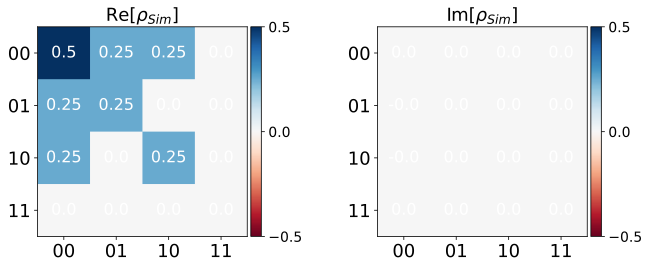

In [333]:
def ideal_rho(phi_I, phi_IS, phi_SL, phi_SR):

    rho = np.zeros((4, 4), dtype = 'complex')

    rho[0, 0] = 0.5
    rho[1, 1] = 0.25
    rho[2, 2] = 0.25

    rho[0, 1] = 1j*np.exp(1j*(phi_IS - phi_SR + phi_I))/4
    rho[0, 2] = 1j*np.exp(1j*(phi_IS - phi_SL + phi_I))/4

    rho[1, 0] = np.conj(rho[0, 1])
    rho[2, 0] = np.conj(rho[0, 2]) 

    rho = qt.Qobj(rho, dims=[[2, 2], [2, 2]])

    return rho 

rho_ideal = ideal_rho(phase_I, phase_IS, phase_SL, phase_SR)
show_plot_rho_2d(rho_sim=rho_ideal.full(), cmax=0.5)



### Generate pulse sequence

QCTRL pulses

In [97]:
from qctrl import Qctrl
from qctrlvisualizer import get_qctrl_style, plot_controls
qctrl = Qctrl()

Q-CTRL package update available.

Your version is 24.0.0. Latest version is 24.2.0.

Visit ]8;id=145838;https://boulder.q-ctrl.com/changelog\boulder.q-ctrl.com/changelog]8;;\ for the latest product updates.


Authentication URL:

https://id.q-ctrl.com/auth/realms/q-ctrl/protocol/openid-connect/auth?response_type=code&client_id=boulder-opal-python&redirect_uri=http%3A%2F%2Flocalhost%3A8000&scope=openid+profile+email+offline_access&state=dDSicskGDrBSMGRbkhisBuORk9c1QD

The URL above should be automatically opened in your default web browser.
(Please copy and paste in case it doesn't open automatically)

Authenticate your credentials in your browser...

Finalizing authentication...
Successful authentication!


In [98]:
# ctrl_result = qctrl.get_result(action_id=1760758)
# ctrl_result = qctrl.get_result(action_id=1761100) # 300 ns Q1 drive only, 16 input states
# ctrl_result = qctrl.get_result(action_id=1761543)
# ctrl_result = qctrl.get_result(action_id=1762374)
# ctrl_result = qctrl.get_result(action_id=1764628)
ctrl_result = qctrl.get_result(action_id=1766039)

  0%|          | 0/100 [00:00<?, ?it/s]

Fidelity: 0.9679242879679109


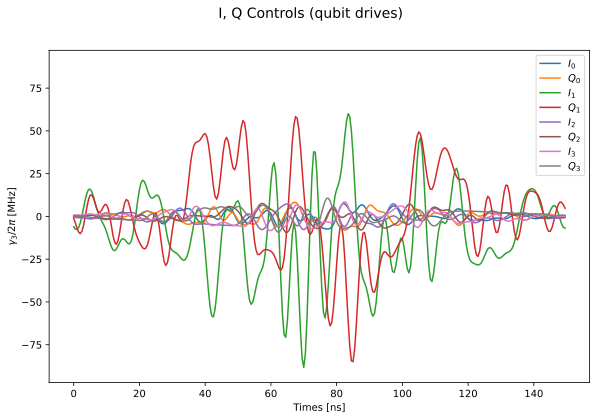

In [103]:
print("Fidelity:", 1-ctrl_result.output["cost"]["value"])

controls = []

control_times = []
I_values_pi = []
Q_values_pi = []
control_qubits = []
for q in range(qram.nqubits):
    if f"$\gammaI_{q}$" not in ctrl_result.output: continue
    I_values_q = []
    Q_values_q = []
    t = 0
    for j in range(2): # I, Q
        name = f"$\gamma{'I' if j==0 else 'Q'}_{q}$"
        control = ctrl_result.output[name]
        for step, pulse in enumerate(control):
            if q==1 and j==0: control_times.append(t)
            t += pulse['duration']
            # factor of 1/2, -1, and 2pi due to how their controls are defined relative to ours
            if j==0: I_values_q.append(pulse['value'])
            else: Q_values_q.append(pulse['value'])

    # append to controls in same order as PICO/ALTRO pulses
    controls.append(-np.array(Q_values_q))
    controls.append(np.array(I_values_q))

    I_values_pi.append(I_values_q)
    Q_values_pi.append(Q_values_q)
    control_qubits.append(q)

control_times = np.array(control_times)
I_values_pi = np.array(I_values_pi)
Q_values_pi = np.array(Q_values_pi)
control_qubits = np.array(control_qubits)

I_values = I_values_pi
Q_values = Q_values_pi
# plt.figure(figsize=(6,8))
plt.suptitle('I, Q Controls (qubit drives)', fontsize=14)
ymax = 1.1*max(abs(np.concatenate((I_values.flatten(), Q_values.flatten()))))

controls_index = 0
for q in range(qram.nqubits):
    if f"$\gammaI_{q}$" not in ctrl_result.output: continue
    # plt.subplot(int(f'41{q+1}'))
    plt.plot(control_times, 1e3*I_values[controls_index], label=f'$I_{q}$')
    plt.plot(control_times, 1e3*Q_values[controls_index], label=f'$Q_{q}$')
    plt.ylim(-1e3*ymax, 1e3*ymax)
    plt.ylabel(f'$\gamma_{q}/2\pi$ [MHz]')
    plt.legend()
    controls_index += 1
plt.xlabel('Times [ns]')
# plt.tight_layout()
plt.show()

PICO pulses

<KeysViewHDF5 ['pulse', 'ts']>
(240, 6)


 C:\Users\slab\AppData\Local\Temp\ipykernel_21364\2069953320.py: 7DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
 C:\Users\slab\AppData\Local\Temp\ipykernel_21364\2069953320.py: 8

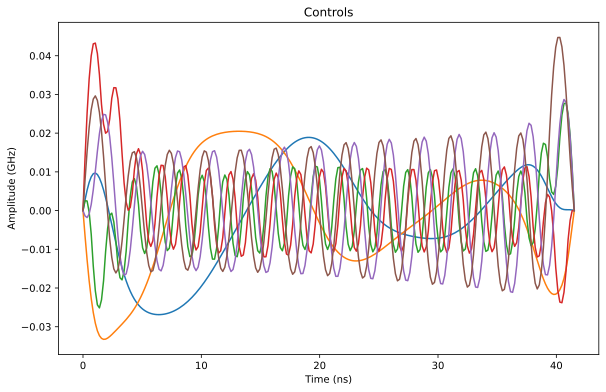

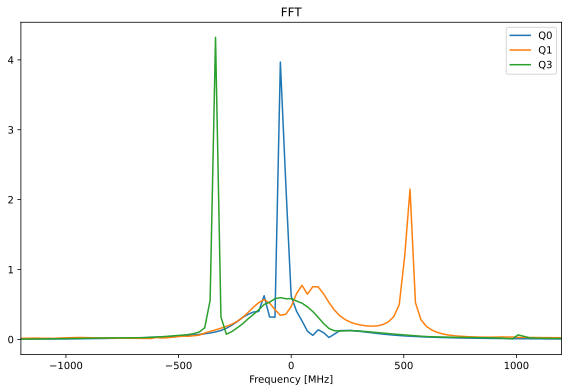

In [73]:
import h5py
filename = 'C:/Users/slab/Downloads/pulse_drives_0_1_3.hdf5'
# filename = 'pulse_all_drives_1.hdf5'
# filename = '../optimal_control/robust-pulses/out/qram/control_transmon_pi/00033_control_transmon_pi.h5'
h5 = h5py.File(filename,'r')
print(h5.keys())
controls = np.array(h5['pulse'])
control_times = np.array(h5['ts'])
print(controls.shape)
plt.plot(control_times, controls)
controls = controls.transpose()
plt.xlabel('Time (ns)')
plt.ylabel('Amplitude (GHz)')
plt.title('Controls')
plt.show()

control_qubits = [0, 1, 3]

control_index = 0
for q in control_qubits:
    controls_q = [controls[2*control_index], controls[2*control_index+1]]
    I_q=controls_q[1]
    Q_q=-controls_q[0]
    fourier = np.fft.fftshift(np.abs(np.fft.fft(I_q + 1j*Q_q)))
    freqs = np.fft.fftshift(np.fft.fftfreq(len(fourier), d=(control_times[1]-control_times[0])))
    plt.plot(1e3*freqs, fourier, label=f'Q{q}')
    control_index += 1
plt.xlabel('Frequency [MHz]')
plt.xlim(-1200, 1200)
plt.title('FFT')
plt.legend()
plt.show()


Altro pulses

<KeysViewHDF5 ['Q', 'Qf', 'R', 'acontrols', 'al_tol', 'astates', 'cmax', 'cmax_info', 'constraint_tol', 'controls_idx', 'd2controls_dt2_idx', 'derivative_count', 'dt', 'evolution_time', 'hdim_iso', 'integrator_type', 'iterations', 'max_cost_value', 'max_iterations', 'max_penalty', 'pn_steps', 'save_type', 'solver_type', 'sqrtbp', 'transmon_state_count', 'ts']>
dt 1.6693376068376067 num steps 60
[25 26]
(52, 60)
(60,)
(2, 61)


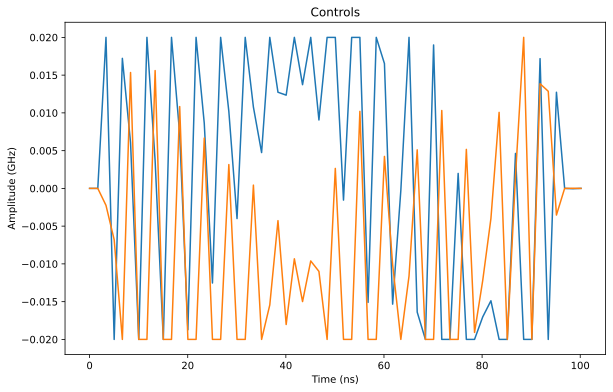

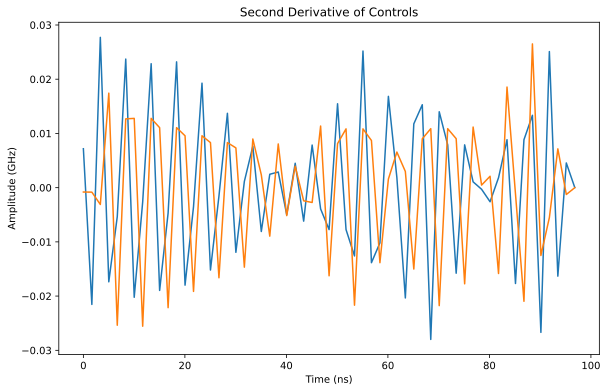

In [12]:
import h5py
filename = '../optimal_control/robust-pulses/out/qram/control_transmon_pi/00033_control_transmon_pi.h5'
h5 = h5py.File(filename,'r')
print(h5.keys())
controls_idx = np.array(h5['controls_idx'])
control_times = np.array(h5['ts'])
print('dt', control_times[1], 'num steps', len(control_times))
print(controls_idx)
print(np.array(h5['astates']).shape)
print(control_times.shape)
controls = np.array(h5['astates'][controls_idx[0]-1:controls_idx[1], :])/2/np.pi
controls = np.array([np.append(controls[0], [0]), np.append(controls[1], [0])])
control_times = np.append(control_times, [control_times[-1]+(control_times[1]-control_times[0])])
controls = np.array(controls)
print(controls.shape)
# for i in range(len(controls)):
#     for j in range(len(controls[0])):
#         controls[i,j] = min(controls[i,j], 0.02)
#         controls[i,j] = max(controls[i,j], -0.02)

plt.plot(control_times, controls[0])
plt.plot(control_times, controls[1])
# plt.ylim(-0.02, 0.02)
plt.xlabel('Time (ns)')
plt.ylabel('Amplitude (GHz)')
plt.title('Controls')
plt.show()

acontrols = np.array(h5['acontrols'])/2/np.pi
plt.plot(control_times[:-2], acontrols[0])
plt.plot(control_times[:-2], acontrols[1])
plt.xlabel('Time (ns)')
plt.ylabel('Amplitude (GHz)')
plt.title('Second Derivative of Controls')
plt.show()

import into pulse sequence

In [200]:
seq = PulseSequence(start_time=0)
# wd00 = qram.get_base_wd('gggg', 'gegg')
# # qram.add_precise_pi_pulse(seq, 'gggg', 'gegg', wd=wd00, amp=0.01, drive_qubit=1, type='gauss', sigma_n=4, phase=0)
# wd01 = qram.get_base_wd('ggge', 'gege')
# qram.add_precise_pi_pulse(seq, 'gggg', 'gegg', wd=(wd00+wd01)/2, amp=0.01, drive_qubit=1, type='gauss', sigma_n=4, phase=0)
# qram.add_precise_pi_pulse(seq, 'gggg', 'gegg', amp=0.015, mu=6, beta=4, drive_qubit=1, type='adiabatic', phase=0, t_pulse=120*4, wd=wd)
# wd00 = qram.add_sequential_pi_pulse(seq, 'gggg', 'gegg', amp=0.01, drive_qubit=1, type='gauss', phase=-np.pi/2, pihalf=False)
# seq.pulse_IQ(wd=wd, amp=1, pulse_levels=('gggg', 'gegg'), I_values=controls[1], Q_values=-controls[0], times=control_times, drive_qubit=1, t_start=0, phase=0)
# seq.pulse_IQ(wd=wd+2*np.pi*5e-3, amp=1, pulse_levels=('gggg', 'gegg'), I_values=controls[1], Q_values=-controls[0], times=times, drive_qubit=1, t_start=0, phase=np.pi/2)

# qram.add_precise_pi_pulse(seq, None, None, amp=None, drive_qubit=0, type='gauss', t_pulse=5.00801282051282, t_offset=0, sigma_n=4)
# qram.add_precise_pi_pulse(seq, None, None, amp=None, drive_qubit=0, type='gauss', t_pulse=5.00801282051282, t_offset=0, sigma_n=4)
# qram.add_precise_pi_pulse(seq, 'ggg', 'geg', wd=2*np.pi*4.381241623620314, amp=0.02086454074773792, drive_qubit=2, type='gauss', sigma_n=4, phase=0, t_pulse=5.00801282051282)
# wd0 = qram.get_base_wd('ggg', 'gge')
# qram.add_precise_pi_pulse(seq, 'ggg', 'gge', wd=wd0, amp=0.02086454074773792, drive_qubit=2, type='gauss', sigma_n=4, phase=0)
# qram.add_precise_pi_pulse(seq, 'ggg', 'gge', wd=2*np.pi*4.381241623620314, amp=0.02086454074773792, drive_qubit=2, type='gauss', sigma_n=4, phase=0, t_pulse=5.00801282051282)
# wd0 = qram.get_base_wd('ggg', 'egg')
# qram.add_precise_pi_pulse(seq, 'ggg', 'egg', wd=wd0, amp=0.01, drive_qubit=0, type='gauss', sigma_n=4, phase=0) #, t_offset=4*5)
# wd0 = qram.get_base_wd('ggg', 'geg')
# qram.add_precise_pi_pulse(seq, 'ggg', 'geg', wd=wd0, amp=0.01, drive_qubit=1, type='gauss', sigma_n=4, phase=0) #, t_offset=4*5)
# qram.add_precise_pi_pulse(seq, 'ggg', 'ggg', amp=0, drive_qubit=1, wd=0, phase=0, type='gauss', t_pulse=5.00801282051282, t_offset=0, sigma_n=4)
wd0 = qram.get_base_wd('ggg', 'egg')
qram.add_precise_pi_pulse(seq, 'ggg', 'egg', wd=wd0, amp=0.01, drive_qubit=0, type='gauss', sigma_n=4, phase=0, t_offset=40)

25.86553583277962

In [105]:
seq = PulseSequence(start_time=0)
# for q in range(4):

qubit_frame = 1 # qubit frequency to rotate at
print(f'using rotating frame of qubit {qubit_frame}')

control_index = 0
for q in control_qubits:
    gstate = 'gggg'
    estate = gstate[:qubit_frame]+'e'+gstate[qubit_frame+1:]
    wd = qram.get_base_wd(gstate, estate)
    print(wd/2/np.pi)
    # wd = 2*np.pi*qram.qubit_freqs[q]
    controls_q = [controls[2*control_index], controls[2*control_index+1]]
    # seq.pulse_IQ(wd=wd, amp=1, pulse_levels=(gstate, estate), I_values=0*controls_q[1], Q_values=-0*controls_q[0], times=control_times, drive_qubit=q, t_start=0, phase=0)
    seq.pulse_IQ(wd=wd, amp=1, pulse_levels=(gstate, estate), I_values=controls_q[1], Q_values=-controls_q[0], times=control_times, drive_qubit=q, t_start=0, phase=0)
    print(f'added pulse IQ on qubit {q}')
    # seq.pulse_IQ(wd=wd, amp=1, pulse_levels=(gstate, estate), I_values=controls_q[1], Q_values=controls_q[0], times=control_times, drive_qubit=q, t_start=0, phase=0)
    control_index += 1

using rotating frame of qubit 1
3.447689269202233
added pulse IQ on qubit 0
3.447689269202233
added pulse IQ on qubit 1
3.447689269202233
added pulse IQ on qubit 2
3.447689269202233
added pulse IQ on qubit 3


In [215]:
seq = PulseSequence(start_time=0)

amp = 0.008
t_pulse = qram.get_Tpi('gggg', 'eggg', amp=amp, drive_qubit=0, type='gauss')

wd00 = qram.add_precise_pi_pulse(seq, 'gggg', 'eggg', amp=amp, t_pulse=t_pulse, drive_qubit=0, type='gauss', phase=0, sigma_n=4)
# qram.add_precise_pi_pulse(seq, 'gggg', 'eggg', amp=amp, wd=wd00, t_pulse=t_pulse, drive_qubit=1, type='gauss', phase=0, t_offset=-seq.get_pulse_lengths()[-1], sigma_n=4)
# qram.add_precise_pi_pulse(seq, 'gggg', 'eggg', amp=amp, wd=wd00, t_pulse=t_pulse, drive_qubit=2, type='gauss', phase=0, t_offset=-seq.get_pulse_lengths()[-1], sigma_n=4)
# qram.add_precise_pi_pulse(seq, 'gggg', 'eggg', amp=amp, wd=wd00, t_pulse=t_pulse, drive_qubit=3, type='gauss', phase=0, t_offset=-seq.get_pulse_lengths()[-1], sigma_n=4)


	new overlap 0.9995967774260415 wd 25.976887684408126 wd_res 0.25
updated drive freq (GHz) from 4.134350081116533 to 4.134350081116533


### Set pulses phases and amps

In [381]:
phase_I = -np.pi/2 # |0+1>
# phase_I = -np.pi # |0+i1>

phase_S = -np.pi/2 #  doesn't affect the protocol implementation, just definining the initialization phase (?)

phase_IS = 0
phase_SL = 0
phase_SR = 0

# amp_swap_01 = 0.050
amp_swap_12 = 0.150
amp_swap_13 = 0.050
amp_pi = 0.005 # pi pulse in the protocol
amp_pi_2 = 0.005 # init pi pulse amp
amp_pi_2_2 = 0.005/10

In [382]:
seq = PulseSequence(start_time=0)


# ---- PREPARE Q1 and Q2

# |0+1>|0>
# wd10 = qram.add_sequential_pi_pulse(seq, 'gggg', 'eggg', amp=amp_pi_2, drive_qubit=0, type='gauss', phase=-np.pi/2, pihalf=True)
# wd10 = qram.add_sequential_pi_pulse(seq, 'gg', 'eg', amp=amp_pi_2, drive_qubit=1, type='gauss', phase=-np.pi/2, pihalf=True)

# # |0>|0+1>
# wd01 = qram.add_sequential_pi_pulse(seq, 'gggg', 'gegg', amp=amp_pi_2, drive_qubit=1, type='gauss', phase=-np.pi/2, pihalf=True)

# # |1>|0+1>
# wd00 = qram.add_sequential_pi_pulse(seq, 'gggg', 'eggg', amp=amp_pi_2, drive_qubit=0, type='gauss', phase=0, pihalf=False)
# wd01 = qram.add_sequential_pi_pulse(seq, 'eggg', 'eegg', amp=amp_pi_2, drive_qubit=1, type='gauss', phase=-np.pi/2, pihalf=True)

# # |0+1>|1>
# wd00 = qram.add_sequential_pi_pulse(seq, 'gggg', 'gegg', amp=amp_pi, drive_qubit=1, type='gauss', phase=0, pihalf=False)
# wd01 = qram.add_sequential_pi_pulse(seq, 'gegg', 'eegg', amp=amp_pi, drive_qubit=0, type='gauss', phase=-np.pi/2, pihalf=True)

# |0+1>|0+1>
wd10 = qram.add_sequential_pi_pulse(seq, 'gggg', 'eggg', amp=amp_pi_2, drive_qubit=0, type='gauss', phase=-np.pi/2, pihalf=True)
wd01 = qram.add_sequential_pi_pulse(seq, 'gggg', 'gegg', amp=amp_pi_2_2, drive_qubit=1, type='gauss', phase=-np.pi/2, pihalf=True)
wd11 = qram.add_sequential_pi_pulse(seq, 'eggg', 'eegg', amp=amp_pi_2_2, drive_qubit=1, type='gauss', phase=-np.pi/2, pihalf=True)
# phase_I = -np.pi/2
# wd00 = qram.add_sequential_pi_pulse(seq, 'gggg', 'eggg', amp=amp_pi_2, drive_qubit=0, type='gauss', phase=-np.pi/2, pihalf=True)
# wd01_1 = qram.get_wd('eggg', 'eegg', amp=amp_pi_2_2, drive_qubit=1, verbose=True)
# Tpi_1 = qram.get_Tpi('eggg', 'eegg', amp=amp_pi_2_2, drive_qubit=1, type='gauss')
# wd01_2 = qram.get_wd('gggg', 'gegg', amp=amp_pi_2_2, drive_qubit=1, verbose=True)
# Tpi_2 = qram.get_Tpi('gggg', 'gegg', amp=amp_pi_2_2, drive_qubit=1, type='gauss')
# wd01 = qram.add_sequential_pi_pulse(seq, 'eggg', 'eegg', amp=amp_pi_2_2, t_pulse=(Tpi_1+Tpi_2)/2/2, drive_qubit=1, type='gauss', phase=phase_I, pihalf=True, wd=np.average((wd01_1, wd01_2)))

# # |0+i1>|0+1>
# phase_I = -np.pi
# wd00 = qram.add_sequential_pi_pulse(seq, 'gggg', 'eggg', amp=amp_pi_2, drive_qubit=0, type='gauss', phase=phase_I, pihalf=True)
# wd01_1 = qram.get_wd('eggg', 'eegg', amp=amp_pi_2_2, drive_qubit=1, verbose=True)
# wd01_2 = qram.get_wd('gggg', 'gegg', amp=amp_pi_2_2, drive_qubit=1, verbose=True)
# wd01 = qram.add_sequential_pi_pulse(seq, 'eggg', 'eegg', amp=amp_pi_2_2, drive_qubit=1, type='gauss', phase=-np.pi/2, pihalf=True, wd=np.average((wd01_1, wd01_2)))


# # ---- FORWARD PROTOCOL ---- 

# # First swap
# print('w_swap_0')
# w_swap_0 = qram.get_wd('eggg', 'gfgg', amp=amp_swap_01, drive_qubit=1, verbose=True)
# wd0 = qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=amp_swap_01, drive_qubit=1, phase=phase_IS, wd=w_swap_0, type='flat_top')

# print('w_swap_1')
# w_swap_1 = qram.get_wd('gfgg', 'ggeg', amp=amp_swap_12, drive_qubit=1, verbose=True)
# wd1 = qram.add_sequential_pi_pulse(seq, 'gfgg', 'ggeg', amp=amp_swap_12, drive_qubit=1, phase=phase_SL, wd=w_swap_1)
# print('wd2')

# #  Second swap
# print('w_pi')
# wd2_1 = qram.get_wd('eegg', 'eggg', amp=amp_pi, drive_qubit=1, verbose=True)
# wd2_2 = qram.get_wd('ggeg', 'geeg', amp=amp_pi, drive_qubit=1, verbose=True)
# wd2_3 = qram.get_wd('gegg', 'gggg', amp=amp_pi, drive_qubit=1, verbose=True)
# wd2 = qram.add_sequential_pi_pulse(seq, 'eegg', 'eggg', amp=amp_pi, drive_qubit=1, 
#                                    wd=np.average((wd2_1, wd2_2, wd2_3)), type='gauss', phase=0)

# print('w_swap_2')
# wd3 = qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=amp_swap_01, drive_qubit=1, wd=w_swap_0, phase=phase_IS)

# print('w_swap_3')
# wd4 = qram.add_sequential_pi_pulse(seq, 'gfgg', 'ggge', amp=amp_swap_13, drive_qubit=1, phase=phase_SR)

# print('w_pi')
# wd5_1 = qram.get_wd('ggge', 'gege', amp=amp_pi, drive_qubit=1, verbose=True)
# wd5_2 = qram.get_wd('geeg', 'ggeg', amp=amp_pi, drive_qubit=1, verbose=True)
# wd5_3 = qram.get_wd('gegg', 'gggg', amp=amp_pi, drive_qubit=1, verbose=True)
# wd5 = qram.add_sequential_pi_pulse(seq, 'ggge', 'gege', amp=amp_pi, 
#                                    drive_qubit=1, wd=np.average((wd5_1, wd5_2, wd5_3)), type='gauss', phase=0)

# ---- NEW FORWARD PROTOCOL ---- 

# # First swap
# print('w_swap_12')
# w_swap_12 = qram.get_wd('gegg', 'ggfg', amp=amp_swap_12, drive_qubit=2, verbose=True)
# wd0 = qram.add_sequential_pi_pulse(seq, 'gegg', 'ggfg', amp=amp_swap_12, drive_qubit=2, phase=phase_IS, wd=w_swap_12, type='flat_top', t_rise=1)
# print(qram.get_wd('gegg', 'ggfg', amp=amp_swap_12, drive_qubit=2, verbose=True)/2/np.pi)

# # Second swap
# print('w_swap_13')
# w_swap_13 = qram.get_wd('eegg', 'eggf',amp=amp_swap_13, drive_qubit=3, verbose=True)
# wd2 = qram.add_sequential_pi_pulse(seq, 'eegg', 'eggf', amp=amp_swap_13, drive_qubit=3, phase=phase_SL, wd=w_swap_13, type='flat_top', t_rise=1)

# # Q2 ef swap
# print('w_swap_Q2_ef')
# w_swap_Q2_ef = qram.get_wd('ggeg', 'ggfg', amp=amp_pi, drive_qubit=2, verbose=True)
# wd1 = qram.add_sequential_pi_pulse(seq, 'ggeg', 'ggfg', amp=amp_pi, drive_qubit=2, phase=0, wd=w_swap_Q2_ef, type='gauss')


# # Q3 ef swap
# print('w_swap_Q3_ef')
# w_swap_Q3_ef = qram.get_wd('ggge', 'gggf', amp=amp_pi, drive_qubit=3, verbose=True)
# wd3 = qram.add_sequential_pi_pulse(seq, 'ggge', 'gggf', amp=amp_pi, drive_qubit=3, phase=0, wd=w_swap_Q3_ef, type='gauss')



# # # print('Done.')

	new overlap 0.9998429109029697 wd 25.8982960089221 wd_res 0.25
updated drive freq (GHz) from 4.1218418274770565 to 4.1218418274770565
	new overlap 0.999992044644256 wd 21.62538107061048 wd_res 0.25
updated drive freq (GHz) from 3.441786293633562 to 3.441786293633562
	new overlap 0.999991677038406 wd 21.592345381269755 wd_res 0.25
updated drive freq (GHz) from 3.436528500376537 to 3.436528500376537


In [111]:
# CHECK FOR CLASHING LEVELS
tolerance = 100*MHz
problem_pulses = qram.check_level_resonances(seq, tolerance=tolerance)
good_freqs = seq.get_pulse_freqs(simplified=True)
print(good_freqs)
if len(problem_pulses.items()) == 0:
    print(f'No clashes found within {tolerance} GHz!')
for good_pulse, problem_pulse_dict in problem_pulses.items():
    print('Clashes to', tolerance,'GHz with', good_pulse[0], '<->', good_pulse[1], f'(freq = {good_freqs[good_pulse]})', 'tpi', qram.get_Tpi(good_pulse[0], good_pulse[1], amp=0.05))
    for problem_pulse, freq in problem_pulse_dict.items():
        diff_freq = np.abs(freq)-np.abs(good_freqs[good_pulse])
        if np.abs(diff_freq) > tolerance:
            diff_freq = 2*np.abs(freq)-np.abs(good_freqs[good_pulse])
        print('\t', 'GOOD PULSE' if problem_pulse in good_freqs.keys() else '', problem_pulse[0], '<->', problem_pulse[1], freq, f'(off by {diff_freq*1e3} MHz)', 'tpi', qram.get_Tpi(problem_pulse[0], problem_pulse[1], amp=0.05))

{('eggg', 'gggg'): 4.144585866376248, ('eegg', 'eggg'): 3.455383606614622, ('eggg', 'gfgg'): 2.667447808234876, ('gfgg', 'ggeg'): 2.0089503481432147, ('gfgg', 'ggge'): 2.394564699713925, ('gege', 'ggge'): 3.4642280305116766}
Clashes to 0.1 GHz with eegg <-> eggg (freq = 3.455383606614622) tpi 10.12120725132859
	 GOOD PULSE gege <-> ggge 3.4642280305116766 (off by 8.844423897054643 MHz) tpi 10.056072934180653
Clashes to 0.1 GHz with gege <-> ggge (freq = 3.4642280305116766) tpi 10.056072934180653
	 GOOD PULSE eegg <-> eggg 3.455383606614622 (off by -8.844423897054643 MHz) tpi 10.12120725132859


In [143]:
import scqubits as sc
EC = 0.280
EJ = 3.470**2/8/EC
print(EJ, EC, EJ/EC)
transmon = sc.Transmon(EJ=EJ, EC=EC, ng=0, ncut=31)

5.375401785714286 0.28 19.197863520408163


(3.1503518059021935, 3.170351805902193)

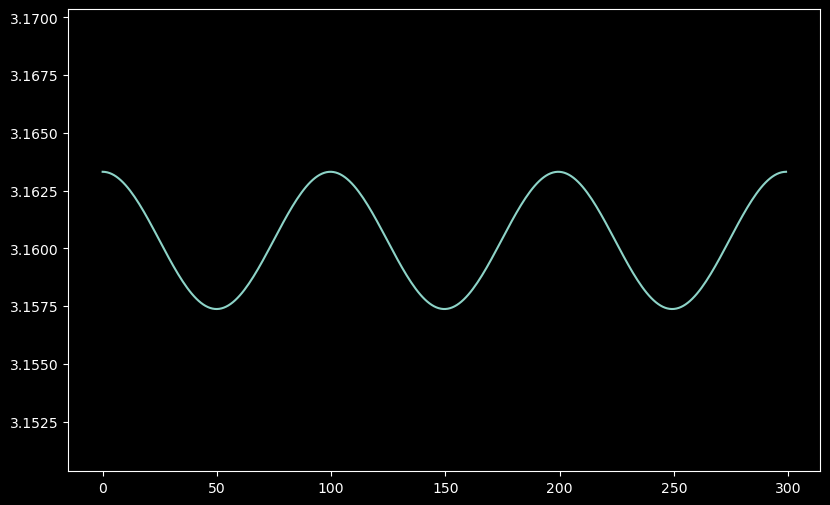

In [144]:
ng_vals = np.linspace(0, 3, 300)

data = transmon.get_spectrum_vs_paramvals('ng', ng_vals, evals_count=6, subtract_ground=False, get_eigenstates=True, filename=None, num_cpus=None)
ge_freq = data.energy_table[:,1] - data.energy_table[:,0]
plt.plot(ge_freq)
plt.ylim(np.average(ge_freq)-0.01, np.average(ge_freq) + 0.01)
# data.plot_evals_vs_paramvals(which=[0, 1],subtract_ground=True)

### Plot pulse seq envelopes

[4.11662788350742] (GHz)
[83.59191005] (ns)
total pulse length 83.59191004702691 ns
{'0': 123.59191004702691}


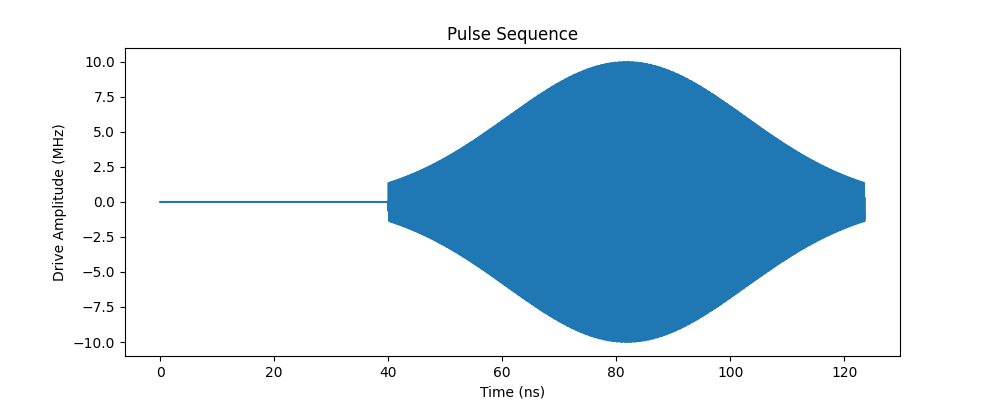

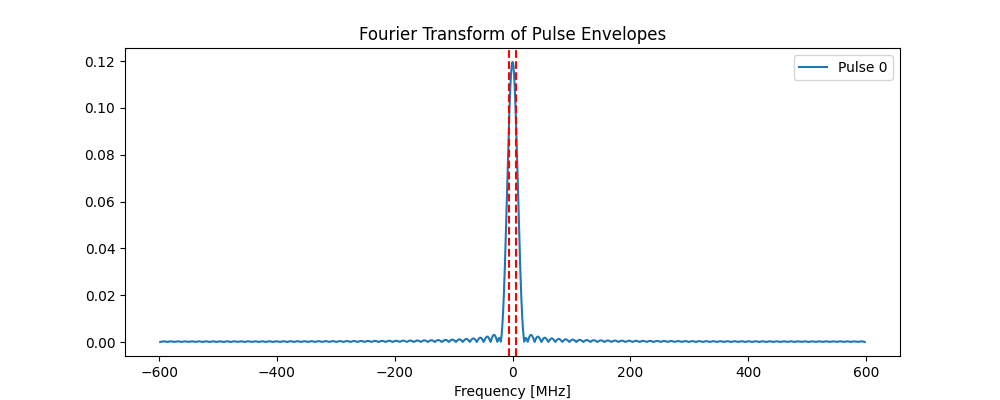

In [201]:
envelope_seq = seq.get_envelope_seq()
pulse_amps = seq.get_pulse_amps()
pulse_freqs = seq.get_pulse_freqs()
pulse_lens = seq.get_pulse_lengths()
drive_funcs = seq.get_pulse_seq()
print(seq.get_pulse_freqs(), '(GHz)')
print(pulse_lens, '(ns)')
print('total pulse length', sum(seq.get_pulse_lengths()), 'ns')

saveplot=False

# times = []
# tot_time = 0
# for pulse_len in pulse_lens:
#     # times.append(np.linspace(tot_time, tot_time + pulse_len, 100))
#     nsteps = 50
#     dt = pulse_len/nsteps
#     if dt > 5: nsteps = int(pulse_len // 10)
#     times = np.append(times, np.linspace(tot_time, tot_time + pulse_len, nsteps))
#     tot_time = tot_time + pulse_len
# print('num time points', len(times))

# times = np.linspace(0, sum(seq.get_pulse_lengths()), 10000)
times = np.linspace(0, seq.get_end_time(), 20000)
# times = np.linspace(0, sum(seq.get_pulse_lengths())+30, 200)
# times = np.linspace(0, sum(seq.get_pulse_lengths()), 50)
# times = np.linspace(0, seq.get_pulse_lengths()[-1], 900)

flat_times = np.array(times).flatten()
# drive_v_times = []
envelope_v_times = []
plt.figure(figsize=(10, 4))
if saveplot: plt.style.use('dark_background')
else: plt.style.use('default')

for i in range(len(envelope_seq)):
    if pulse_amps[i] is not None:
        if isinstance(envelope_seq[i], list) and len(envelope_seq[i]) == 2:
            envelope_v_time_I = [pulse_amps[i]*envelope_seq[i][0](t)/MHz for t in flat_times]
            envelope_v_time_Q = [pulse_amps[i]*envelope_seq[i][1](t)/MHz for t in flat_times]
            plt.plot(flat_times, envelope_v_time_I, label=f'Pulse {i} I')
            plt.plot(flat_times, envelope_v_time_Q, label=f'Pulse {i} Q')
        else:
            # envelope_v_time = [pulse_amps[i]*envelope_seq[i](t)/MHz for t in flat_times]
            envelope_v_time = [drive_funcs[i](t)/MHz for t in flat_times]
            envelope_v_times.append(envelope_v_time)
            color=None
            # if i == 0: color = 'deeppink'
            # else: color = 'deepskyblue'
            plt.plot(flat_times, envelope_v_time, label=f'Pulse {i}', color=color)
plt.xlabel('Time (ns)')
plt.ylabel('Drive Amplitude (MHz)')
# plt.ylim(0, None)
# plt.ylim(-1, 6)
plt.title('Pulse Sequence')
# plt.legend()

savetitle = 'long_plusplus_prep.svg'
if saveplot:
    plt.savefig(savetitle, format='svg', bbox_inches='tight', transparent=True)
    print(f'Saved {savetitle}')

plt.show()


plt.figure(figsize=(10, 4))
fft_times = np.linspace(0, 100*sum(seq.get_pulse_lengths()), 10000) # need the fft times to be >> length of pulse
envelope_v_time_ffts = []
for i in range(len(envelope_seq)):
    if pulse_amps[i] is not None:
        envelope_v_time_fft = [pulse_amps[i]*envelope_seq[i](t)/MHz for t in fft_times]
        fourier = 2/len(fft_times) * np.abs(np.fft.fftshift(np.fft.fft(envelope_v_time_fft)))
        freqs = np.fft.fftshift(np.fft.fftfreq(len(fourier), d=(fft_times[1]-fft_times[0])))
        envelope_v_time_ffts.append(fourier)
        color=None
        # if i == 0: color = 'deeppink'
        # else: color = 'deepskyblue'
        plt.plot(1e3*freqs, fourier, label=f'Pulse {i}', color=color)
        plt.axvline(5.25, color='r', linestyle='--')
        plt.axvline(-5.25, color='r', linestyle='--')
plt.xlabel('Frequency [MHz]')
plt.legend()
# plt.xlim(4, 8)
# plt.ylim(0, 20000)
plt.title(f'Fourier Transform of Pulse Envelopes')
# savetitle = 'long_plusplus_prep_FT.svg'
if saveplot:
    plt.savefig(savetitle, format='svg', bbox_inches='tight', transparent=True)
    print(f'Saved {savetitle}')
plt.show()


## Run simulation

In [48]:
T1 = 60e3 # ns
T2 = 30e3 # ?

# T1 = 10e3

# c_ops = [
#     np.sqrt(1/T1)*qram.a,
#     np.sqrt(1/T1)*qram.b,
#     np.sqrt(1/T1)*qram.c,
#     np.sqrt(1/T1)*qram.d,
# ]

c_ops = None

Make extended qram state given 2q tomo result (e.g. from experiment) - assumes all other states are 0

In [20]:
exptpsi0 = np.array(
[[ 0.28 +0.j,    -0.052+0.118j,  0.162-0.116j, -0.08 -0.028j],
 [-0.052-0.118j,  0.265+0.j,     0.023+0.02j,  -0.154+0.077j],
 [ 0.162+0.116j,  0.023-0.02j,   0.276+0.j,    -0.093-0.02j ],
 [-0.08 +0.028j, -0.154-0.077j, -0.093+0.02j,   0.18 +0.j   ]])

exptpsi0 = np.array(
[[0.25, 0.25, 0.25, 0.25],
 [0.25, 0.25, 0.25, 0.25],
 [0.25, 0.25, 0.25, 0.25],
 [0.25, 0.25, 0.25, 0.25]] 
)

psi0 = 0*qt.ket2dm(qram.state('gggg'))
for i in range(len(exptpsi0)):
    for j in range(len(exptpsi0[0])):
        iq0 = i // 2
        iq1 = i % 2
        jq0 = j // 2
        jq1 = j % 2
        # print(iq0, iq1, jq0, jq1, exptpsi0[i,j])
        psi0 += exptpsi0[i, j] * qram.make_bare((iq0, iq1, 0, 0)) * qram.make_bare((jq0, jq1, 0, 0)).dag()
psi0 = psi0.unit()
# print(psi0)
# print(gggg)
# np.abs([gggg.dag()*psi0*gggg])

SIMULATE

In [202]:
# psi0_name = 'eggg'
# psi0_name = 'gfgg'
# psi0_name = 'efgg'
# psi0_name = 'eegg'
# psi0_name = 'ggeg'
# psi0_name = 'ggge'

psi0 = qram.state('ggg') # QRAM start |0>|0>

# psi0 = qram.state('gggg') # QRAM start |0>|0>
# psi0 = qram.state('eegg') # QRAM start |1>|1>
# psi0 = (qram.state('ggeg') + qram.state('geeg')).unit()
# psi0 = (qram.state('ggge') + qram.state('gege')).unit()
# psi0 = (qram.state('gegg') + qram.state('eegg')).unit() # QRAM start |0+1>|1>
# psi0 = (qram.state('eggg') + qram.state('eegg')).unit() # QRAM start |1>|0+1>
# psi0 = (qram.state('gggg') + qram.state('gegg')).unit() # QRAM start |0>|0+1>
# psi0 = (qram.state('eggg') + qram.state('eegg') + qram.state('gggg') + qram.state('gegg')).unit() # QRAM start |0+1>|0+1>
# psi0 = (1j*qram.state('eggg') + 1j*qram.state('eegg') + qram.state('gggg') + qram.state('gegg')).unit() # QRAM start |0+i1>|0+1>

# result_lab = qram.evolve(psi0, seq, times, c_ops=None, nsteps=200, use_str_solve=False)
result_lab = qram.evolve(psi0, seq, times, c_ops=None, nsteps=20000, max_step=0.1, use_str_solve=False)
# result = qram.evolve_rot_frame(psi0, seq, times, c_ops=None, nsteps=20000)

# gstate = 'gggg'
# estate = gstate[:qubit_frame]+'e'+gstate[qubit_frame+1:]
# wd = qram.get_base_wd(gstate, estate)
# print(wd/2/np.pi)
# result_lab = qt.mesolve(qram.H_solver_rot_wd(seq=seq, wframe=wd), psi0, times, progress_bar=True, options=qt.Options(nsteps=1000)).states

[Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.         27.528153    0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.         29.94909782  0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.         57.47362289  0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.         25.86553583  0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.         53.38988968
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  55.8135965   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.         83.33432242]], [Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[0.         0.         0.         0.   

In [203]:
# result = [result_lab_t.unit() for result_lab_t in result_lab]
result = result_lab

Save result state

In [ ]:
# import sys
# orig_stdout = sys.stdout
# with open('forward_protocol_input0plusi1_switch5050.txt', 'w') as f:
#     sys.stdout = f
#     print(result)
#     sys.stdout = original_stdout
print(result)

In [355]:
result_dict = dict()

In [372]:
result_dict.update({'|1>|0+1>':result})

In [406]:
result = result_dict['|0+i1>|0+1>']

Plot evolution results

ggg
gge
geg
gee
egg
ege
eeg
eee


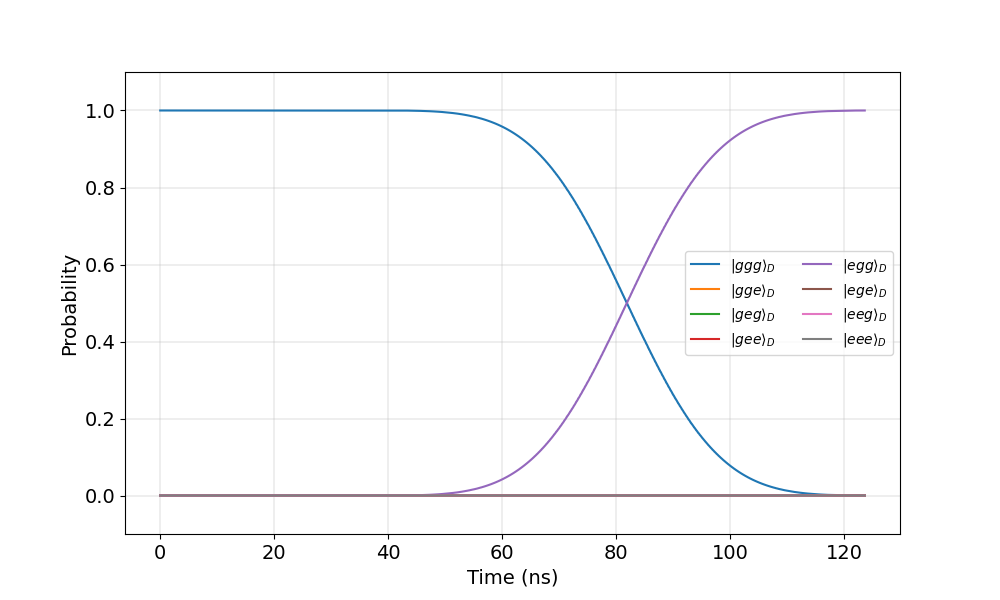

In [204]:
saveplot = False

plt.figure(figsize=(10,6))
if saveplot: plt.style.use('dark_background')

# states for 1 input
# plot_states = ['eggg', 'gfgg', 'ggeg', 'eegg', 'ggge', 'geeg', 'gege', 'gggg', 'gegg']
# plot_states = ['eggg', 'gfgg', 'ggeg', 'eegg', 'ggge', 'geeg', 'gege', 'gggg', 'gegg', 'efgg'] #, 'ehgg', 'ghgg']
# plot_states = ['gggg', 'eggg', 'eegg', 'gegg', 'ggfg', 'eggf', 'egfg', 'gggf', 'ggeg', 'egge']

plot_states = ['ggg', 'gge', 'geg', 'gee', 'egg', 'ege', 'eeg', 'eee']

prob_states = dict()
for state in plot_states:
    print(state)
    psi = qram.state(state)
    prob_states.update({state:[np.abs(psi.overlap(result[t]))**2 for t in range(len(times))]})

for state in plot_states:
    plt.plot(times, prob_states[state], label=rf'$|{state}\rangle_D$')

plt.legend(fontsize=10, ncol=2)
plt.ylim(-0.1, 1.1)
# plt.axvline(220)
# plt.xlim(750, 1000)
plt.tick_params(labelsize=14)
plt.xlabel('Time (ns)', fontsize=14)
plt.ylabel('Probability', fontsize=14)
# plt.title(r'$\psi_0=|$'+psi0_name+r'$\rangle$')
# plt.title('QRAM state evolution in memory access operation')
plt.grid(linewidth=0.3)

if saveplot:
    plot_filename = 'qram_protocol_simulated.png'
    plt.savefig(plot_filename, format='png', bbox_inches='tight', transparent = True)
    print('Saved', plot_filename)

plt.show()

Get non zero levels

In [54]:
max_prob = 0.001

T = times[-1] # ns

sum_psi = 0
T = np.argmin(np.abs(times-T))
probs = dict()
print(f"Non-zero levels to {max_prob*100}% error:")
for i1 in range(cutoffs[0]):
    for i2 in range(cutoffs[1]):
        for i3 in range(cutoffs[2]):
            for i4 in range(cutoffs[3]):
                prob = np.abs(qram.state([i1, i2, i3, i4]).overlap(result[T]))**2
                if prob > max_prob:
                    probs.update({qram.level_nums_to_name([i1, i2, i3, i4]):prob})
                    sum_psi += prob
probs = sorted(probs.items(), key=lambda item:-item[1])
for level, prob in probs:
    print(level, '(%):', prob*100)
print('Sum probabilities (%):', sum_psi*100)

Non-zero levels to 0.1% error:
ggeg (%): 49.88401199764908
egge (%): 47.881683629334304
eggf (%): 1.6007002470162714
egeg (%): 0.39852505136691324
gegg (%): 0.12932011292777842
Sum probabilities (%): 99.89424103829437


Max fidelity [%]: 99.99999999999997
Final fidelity [%]: 9.695354809738618


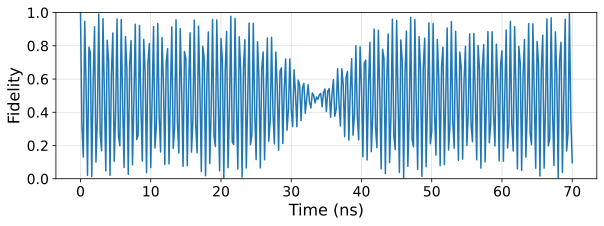

In [ ]:
# ket_target = qram.state('ggeg')
ket_target = (qram.state('gegg') + qram.state('gggg')).unit()
qram.fidelity(qram.state('ggeg'), result[-1])
qram.fidelity(qram.state('gege'), result[-1])

fidelities = [qram.fidelity(ket_target, result[t]) for t in range(len(times))]
print(f'Max fidelity [%]: {1e2*max(fidelities)}')
print(f'Final fidelity [%]: {1e2*fidelities[-1]}')

plt.figure(figsize=(9.7,3))
plt.plot(times, fidelities)

# plt.legend(fontsize=16, ncol=2)
plt.ylim(0, 1)
# plt.xlim(750, 1000)
plt.tick_params(labelsize=14)
plt.xlabel('Time (ns)', fontsize=16)
plt.ylabel('Fidelity', fontsize=16)
# plt.title(r'$\psi_0=|$'+psi0_name+r'$\rangle$')
# plt.title('QRAM state evolution in memory access operation')
plt.grid(linewidth=0.3)
plt.show()

## Truncate result so it's compatible with 2q tomography

Unrotate when solving in the rotating frame of wd

In [56]:
esys_rot_wd = qram.H_rot(wd=wd).eigenstates()
evals, evecs = esys_rot_wd
def unrotate(result, t):
    # return result
    result_rot = 0*result
    evals, evecs = esys_rot_wd
    for eval, evec in zip(evals, evecs):
        # |a> = sum_i(|biXbi|a>), a.overlap(b) = <a|b>
        evec_flat = evec.full().flatten()
        overlap = np.sum(np.conj(evec_flat) * result.full().flatten())
        # print(eval)
        result_rot += np.exp(1j*eval*t) * overlap * evec
    return result_rot
result = [unrotate(result_lab[-1], times[-1])]

NameError: name 'wd' is not defined

Unrotate when solving in the lab frame

In [19]:
# result = qram.evolve_unrotate(times=times, result=result_lab)
result = qram.evolve_unrotate(times=[times[-1]], result=[result_lab[-1]])

100%|██████████| 1/1 [00:00<00:00, 499.80it/s]


### Get 2Q partial trace density matrix

Get ideal rho

In [ ]:
psi0 = '(g+e)(g+ie)gg'
result = [qt.Qobj(ctrl_result.output[psi0]['value'][t], dims = [[3, 3, 3, 3], [1, 1, 1, 1]], shape = (81, 1)) for t in range(len(ctrl_result.output[psi0]['value']))]

In [377]:
psiZ = [qt.basis(2,0), qt.basis(2,1)]
psi00 = qt.tensor(psiZ[0], psiZ[0])
psi01 = qt.tensor(psiZ[0], psiZ[1])
psi10 = qt.tensor(psiZ[1], psiZ[0])
psi11 = qt.tensor(psiZ[1], psiZ[1])

rho_ids = dict()
rho_ids.update({'|0>|0+1>':qt.ket2dm(psi00).unit()})
rho_ids.update({'|1>|0+1>':(qt.ket2dm(psi10) + qt.ket2dm(psi01)).unit()})
rho_ids.update({'|0+1>|0+1>':(qt.ket2dm(psi00 + psi10) + qt.ket2dm(psi00 + psi01)).unit()})
rho_ids.update({'|0+i1>|0+1>':(qt.ket2dm(psi00 + 1j*psi10) + qt.ket2dm(psi00 + 1j*psi01)).unit()})

rho_id = rho_ids['|0+i1>|0+1>']

# rho_id = qt.ket2dm(qt.tensor(psiZ[0]+psiZ[1], psiZ[0]+psiZ[1])).unit()
# rho_id = qt.ket2dm(psi10 + psi11).unit()
# rho_id = qt.ket2dm(psi00 - 1j*psi01 + psi10 - 1j*psi11).unit()
# rho_id = qt.ket2dm(psi11).unit()

Quantum object: dims = [[4, 5], [4, 5]], shape = (20, 20), type = oper, isherm = True
Qobj data =
[[ 2.51668702e-01+4.59041935e-19j  2.66916348e-01+3.33063408e-02j
   2.31092893e-02+3.19437947e-03j  1.96726590e-05-1.74862431e-05j
  -1.08789144e-08-2.60084225e-09j  2.29652571e-01+2.70759315e-02j
   2.42111473e-01+2.96418239e-02j  1.80228081e-04-1.56869908e-04j
  -9.36652096e-08-2.21668614e-08j -1.71303687e-12+2.05632383e-11j
  -4.12360092e-02-4.31837653e-03j -3.51314679e-05+2.07955851e-05j
   1.36061030e-08+1.69852880e-08j -1.81729103e-12-1.46331905e-11j
   2.20054449e-12-3.16691712e-12j  3.57438617e-06+8.60235407e-07j
  -5.11259544e-09-6.25063644e-09j -7.17683152e-12-1.63039404e-11j
   7.44025876e-12-8.65510560e-12j -4.49076222e-12+3.20448449e-11j]
 [ 2.66916348e-01-3.33063408e-02j  2.88627922e-01-1.51411510e-18j
   2.50629305e-02+3.26271743e-04j  1.86435581e-05-2.12641554e-05j
  -1.19452329e-08-1.32305899e-09j  2.47469518e-01-1.57535688e-03j
   2.62071020e-01-6.62120119e-04j  1.712417

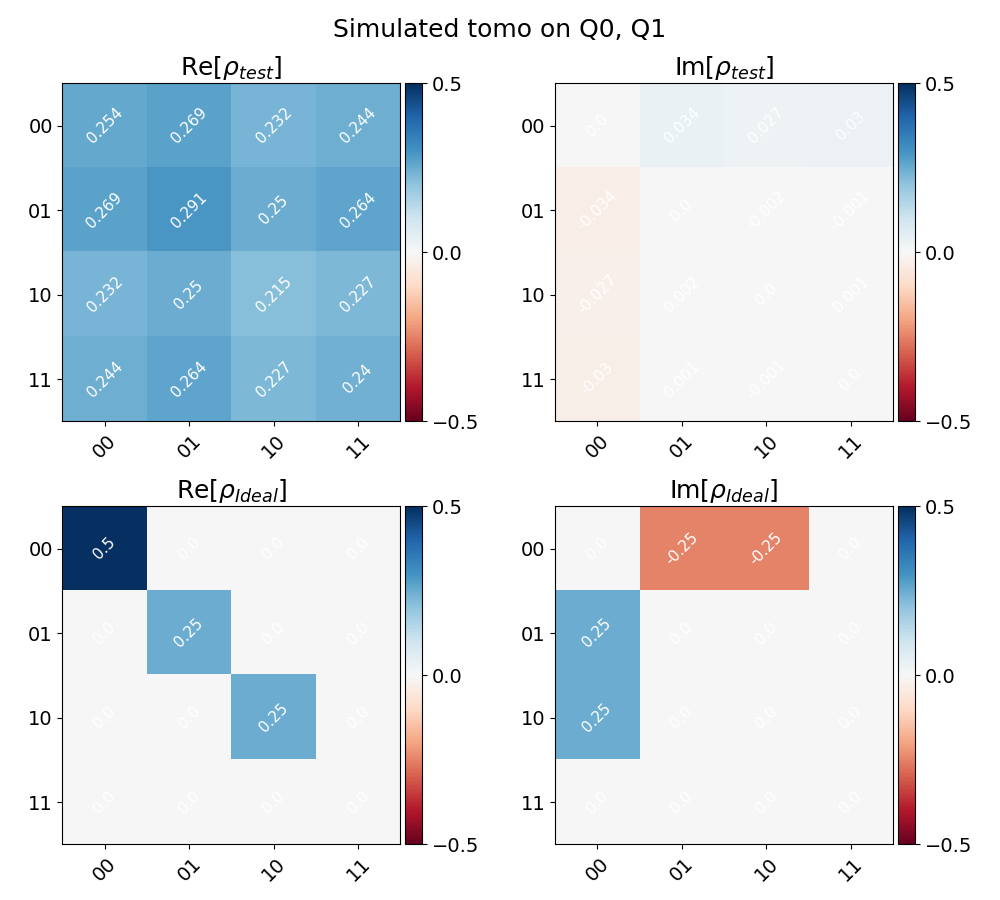

Fidelity: 0.2307927953952376
Purity (sim): 0.9978065477647046
Purity (ideal): 0.6249999910579696


In [380]:
# print(result[-1].dims)
tomo_qubits = [0, 1]
# tomo_qubits = [2, 3]
# tomo_qubits = [1, 2]
# tomo_qubits = [1, 3]
result2q = qt.ptrace(result[-1].unit(), tomo_qubits)
# result2q = qt.ptrace(psi0, tomo_qubits)
orig_dims = result2q.dims[0]
# result2q = qt.ptrace(result.unit(), tomo_qubits)
# print('orig dims', orig_dims)
# rho_result2q = result2q
print(result2q)

states_inds = [i*orig_dims[1]+ j for i in range(2) for j in range(2)]
# print('extract state indices', states_inds)
rho_result2q = result2q.extract_states(states_inds, normalize=True)


id2q = qt.tensor(qt.qeye(2), qt.qeye(2))
rho_result2q  = qt.Qobj(rho_result2q , dims=id2q.dims, shape=id2q.shape).unit()
print(rho_result2q)

show_plot_rho_2d(rho_MLE=rho_result2q.full(), rho_id=rho_id.full(), num_tomo=2, title=f'Simulated tomo on Q{tomo_qubits[0]}, Q{tomo_qubits[1]}', cmax=0.5) #, savetitle='0_0+1_simulated_flat.png') #, cmax=1.0)

fid = qt.fidelity(rho_result2q, rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
purity_sim = np.real(np.trace(rho_result2q.full() @ rho_result2q.full()))
purity_id = np.real(np.trace(rho_id.full() @ rho_id.full()))
print(f'Fidelity: {fid}')
print(f'Purity (sim): {purity_sim}')
print(f'Purity (ideal): {purity_id}')

Define virtual Z gate optimization 

In [55]:
def z_gate_2q(phi1, phi2):
    return qt.tensor(qt.qip.operations.gates.rz(phi1), qt.qip.operations.gates.rz(phi2)) 

# The simulation density matrix from MLE may be offset from the ideal density matrix by a Z gate - due to different pulse times, ac stark shifts, etc. Rotate rho_rot to best match rho_target
def opt_virtualZ_MLE(rho0, rho_target, nphi=100, phi_mins=[0]*2, phi_maxs=[2*np.pi]*2):
    phis1 = np.linspace(phi_mins[0], phi_maxs[0], nphi)
    phis2 = np.linspace(phi_mins[1], phi_maxs[1], nphi)
    best_fid = qt.fidelity(rho0, rho_target)**2
    all_fids = []
    best_phis = [0, 0]
    best_rho_rot = rho0
    for phi1 in tqdm(phis1):
        for phi2 in phis2:
            z_phi12 = z_gate_2q(phi1, phi2)
            rho_rot = (z_phi12*rho0*z_phi12.dag()).unit()
            fid = qt.fidelity(rho_rot, rho_target)**2
            all_fids.append(fid)
            # print(fid)
            if fid > best_fid:
                best_fid = fid
                best_phis = [phi1, phi2]
                best_rho_rot = rho_rot
    print(f'Improved fidelity by (%) {(best_fid - qt.fidelity(rho0, rho_target)**2)*100}')
    all_fids = np.array(all_fids)
    all_fids = np.reshape(all_fids, (nphi, nphi))
    return best_rho_rot, best_phis, best_fid, all_fids

Optimize over virtual Z gates

In [105]:
rho_result2q = qt.Qobj(inpt=np.array( # |1>|0+1> input, forward simulation smaller amps, averaged pi pulses, q2/q3
[[ 0.592+0.j   , -0.008-0.172j, -0.201+0.033j, -0.011+0.014j],
 [-0.008+0.172j,  0.285+0.j   , -0.045-0.005j, -0.017-0.017j],
 [-0.201-0.033j, -0.045+0.005j,  0.094+0.j   , -0.008+0.005j],
 [-0.011-0.014j, -0.017+0.017j, -0.008-0.005j,  0.028+0.j   ]]),
                 dims=rho_id.dims, shape=rho_id.shape)

100%|██████████| 25/25 [00:02<00:00, 11.73it/s]


Improved fidelity by (%) 4.661146227519108
Fidelity (after rotation round 1): 0.7625017871599762
Best rotation round 1: [0.7853981633974483, 5.759586531581287]


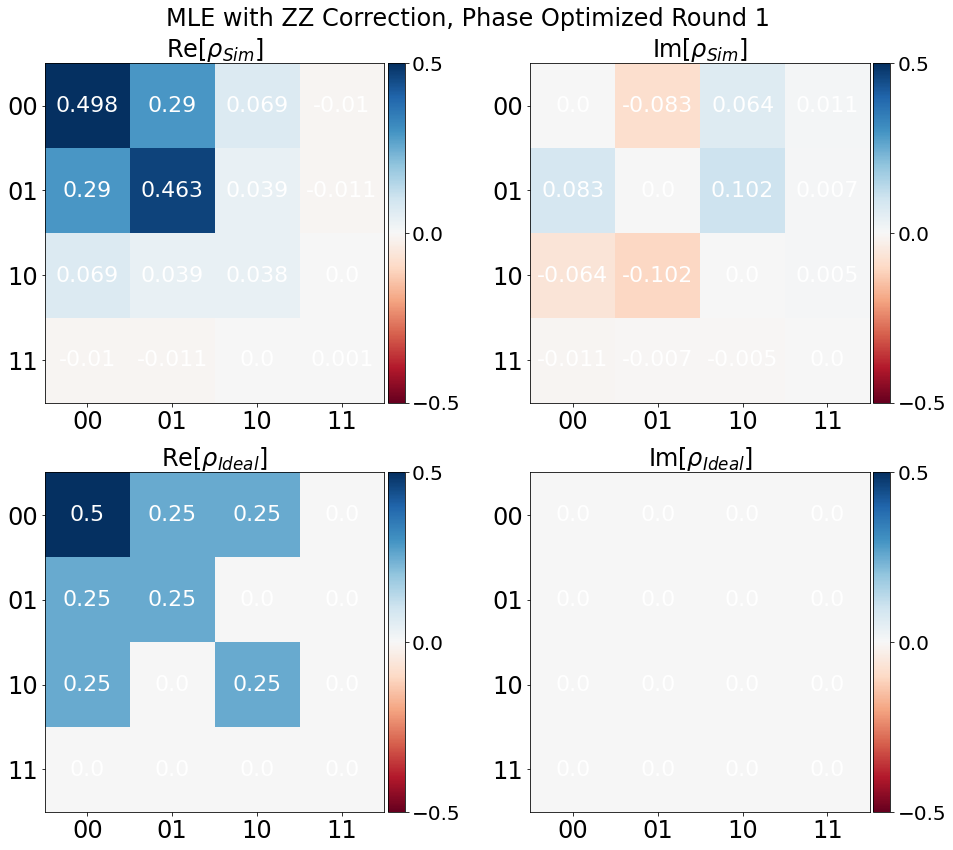

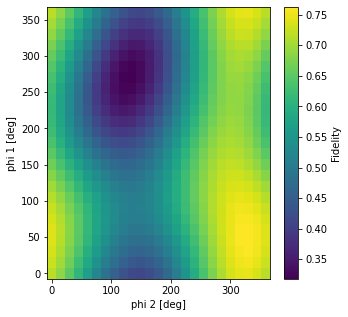

100%|██████████| 25/25 [00:02<00:00, 11.72it/s]


Improved fidelity by (%) 4.708141887910699
[[ 0.498+0.j     0.295-0.065j  0.075+0.057j -0.009+0.011j]
 [ 0.295+0.065j  0.463+0.j     0.055+0.094j -0.01 +0.008j]
 [ 0.075-0.057j  0.055-0.094j  0.038+0.j    -0.   +0.005j]
 [-0.009-0.011j -0.01 -0.008j -0.   -0.005j  0.001+0.j   ]]
Fidelity (after rotation round 2): 0.7629717437638921
Best rotation round 2: [0.890117918517108, 5.696754678509491]


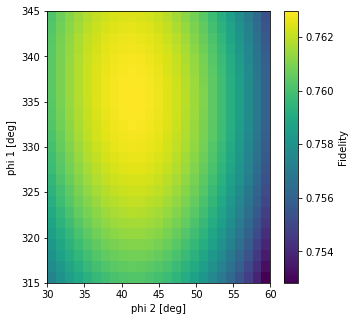

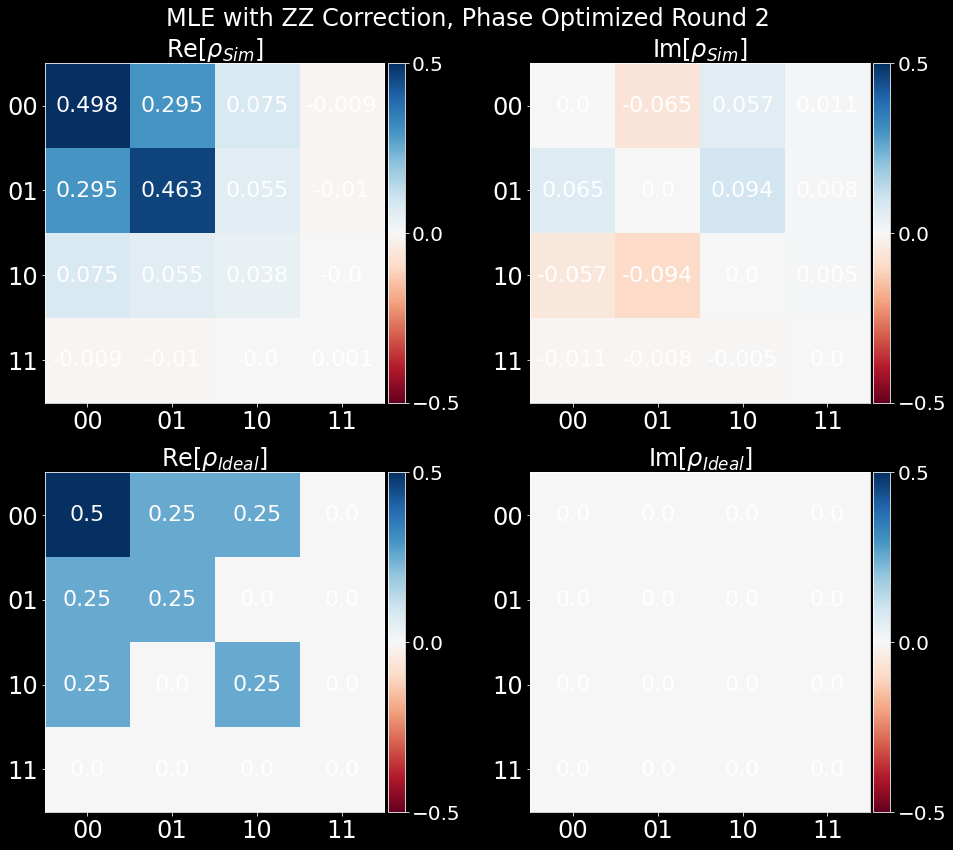

 <ipython-input-3-2e4d5b4b62eb>: 73MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
 <ipython-input-3-2e4d5b4b62eb>: 84UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
 <ipython-input-3-2e4d5b4b62eb>: 91

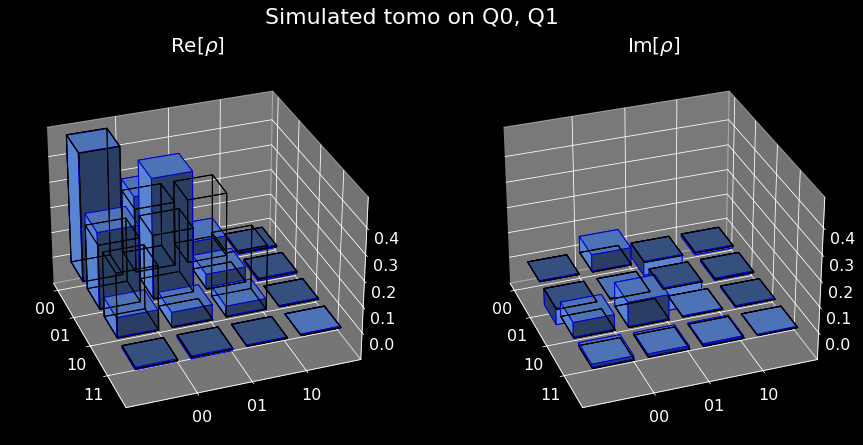

In [56]:
nphi_round1 = 25
nphi_round2 = 25

rho_rot, best_phis, best_fid, all_fids = opt_virtualZ_MLE(qt.Qobj(rho_result2q, dims=rho_id.dims), rho_id, nphi=nphi_round1)

fid_ZZ_rot = best_fid
print(f'Fidelity (after rotation round 1): {fid_ZZ_rot}')
print(f'Best rotation round 1: {best_phis}')
show_plot_rho_2d(rho_rot, rho_id, title='MLE with ZZ Correction, Phase Optimized Round 1') #, cmax=1.0)

phis = np.linspace(0, 2*np.pi, nphi_round1)
plt.figure(figsize=(5,5))
plt.pcolormesh(phis*180/np.pi, phis*180/np.pi, all_fids, cmap='viridis', shading='auto')
plt.xlabel("phi 2 [deg]")
plt.ylabel("phi 1 [deg]")
plt.colorbar(label='Fidelity')
plt.show()

phi_mins = np.array(best_phis)-2*np.pi/nphi_round1
phi_maxs = np.array(best_phis)+2*np.pi/nphi_round1
rho_rot, best_phis, best_fid, all_fids = opt_virtualZ_MLE(qt.Qobj(rho_result2q, dims=rho_id.dims), rho_id, nphi=nphi_round2, phi_mins=phi_mins, phi_maxs=phi_maxs)
fid_ZZ_rot = best_fid
print(np.around(rho_rot, decimals=3))
print(f'Fidelity (after rotation round 2): {fid_ZZ_rot}')
print(f'Best rotation round 2: {best_phis}')

phis1 = np.linspace(phi_mins[0], phi_maxs[0], nphi_round2)
phis2 = np.linspace(phi_mins[1], phi_maxs[1], nphi_round2)
plt.figure(figsize=(5,5))
plt.pcolormesh(phis1*180/np.pi, phis2*180/np.pi, all_fids, cmap='viridis', shading='auto')
plt.xlabel("phi 2 [deg]")
plt.ylabel("phi 1 [deg]")
plt.colorbar(label='Fidelity')
plt.show()

show_plot_rho_2d(rho_rot, rho_id, title='MLE with ZZ Correction, Phase Optimized Round 2', cmax=None, savetitle='0+1_0+1_simulated_flat.png')
show_plot_rho_3d(rho_sim=rho_rot.full(), rho_id=rho_id.full(), title=f'Simulated tomo on Q{tomo_qubits[0]}, Q{tomo_qubits[1]}', width=0.75, elev=30, azim=-20) #, savetitle='0+1_0+1_simulated.png')

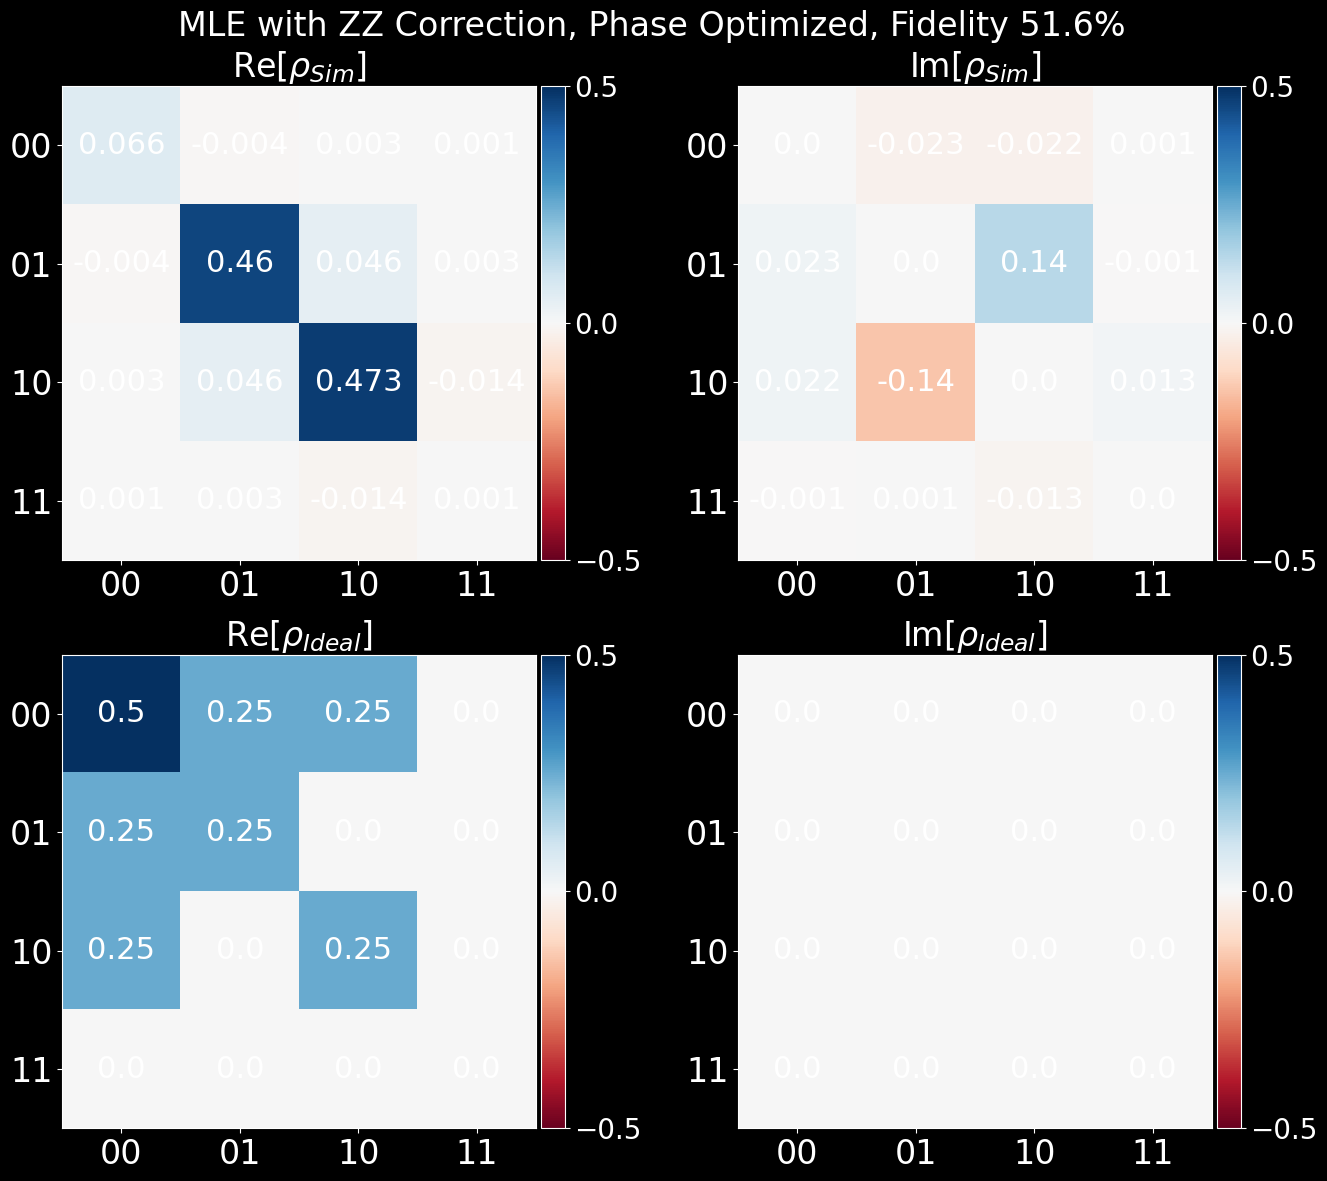

 <ipython-input-11-2e4d5b4b62eb>: 91

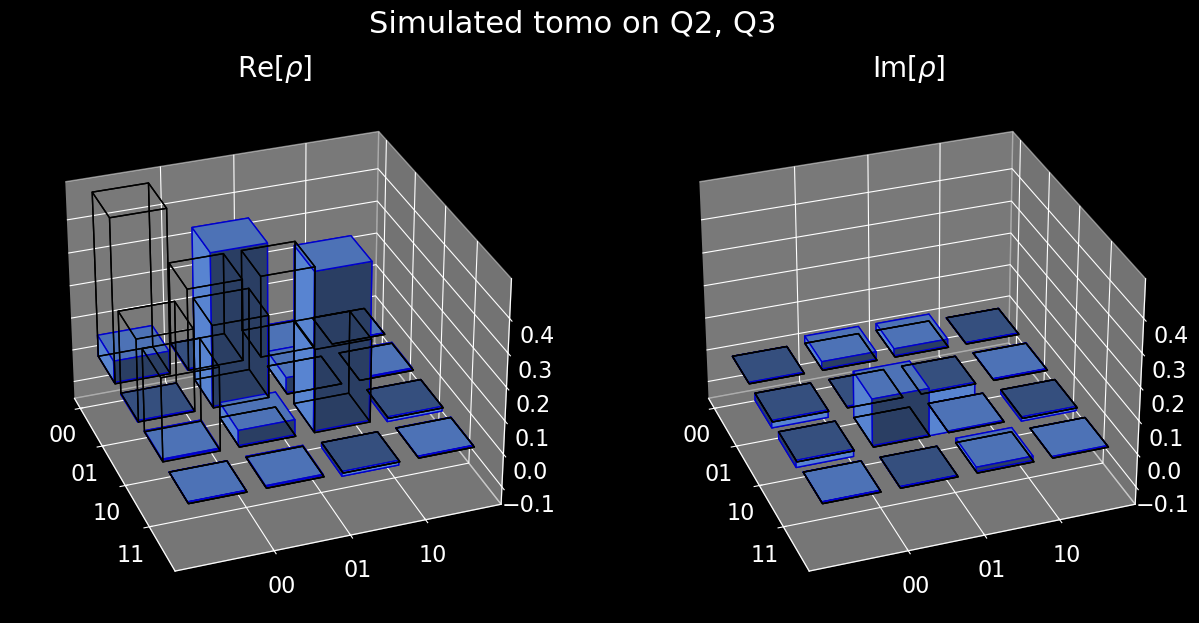

In [ ]:
z_phi12 = z_gate_2q(2.4609142453120043, 3.7699111843077517)
rho_rot = (z_phi12*rho_result2q*z_phi12.dag()).unit() 
fid = qt.fidelity(rho_rot, rho_id)**2
show_plot_rho_2d(rho_rot, rho_id, title=f'MLE with ZZ Correction, Phase Optimized, Fidelity {100*fid:.3}%', cmax=None, savetitle='0+i1_0+1_simulated_flat.png')
show_plot_rho_3d(rho_sim=rho_rot.full(), rho_id=rho_id.full(), title=f'Simulated tomo on Q{tomo_qubits[0]}, Q{tomo_qubits[1]}', width=0.75, elev=30, azim=-20) #, savetitle='0+1_0+1_simulated.png')

In [12]:
print('want', qram.get_base_wd('eggg', 'gfgg')/2/np.pi)
print('want', qram.get_base_wd('eegg', 'eggg')/2/np.pi)
# print('want', qram.get_wd('eggg', 'gfgg', 0.10, verbose=False)/2/np.pi)
# print('want', qram.get_wd('eegg', 'gfgg', 0.10, verbose=False)/2/np.pi)
# print('want', qram.get_wd('ggge', 'gege', 0.05, verbose=False)/2/np.pi)
# print('resonant to', qram.get_wd('ggeg', 'geeg', 0.05)/2/np.pi)
# print('2 photon transition to', qram.get_base_wd('eggg', 'efgg')/2/np.pi)

want 2.1692639480132065
want 3.6869102975757024


### Get 3Q partial trace density matrix

Get ideal rho

In [258]:
# Define the basis of psis
psi_basis = dict()
psi_basis.update({'ZZZ':[]})
for state1 in (0,1):
    for state2 in (0,1):
        for state3 in (0,1):
            psi_basis['ZZZ'].append(qt.tensor(psiZ[state1], psiZ[state2], psiZ[state3]).unit())

psiZ = [qt.basis(2,0), qt.basis(2,1)]
psis = dict() # psis in the ZZZ basis
print(get_tomo_labels(3))
for i, label_numeric in enumerate(get_tomo_labels(num_tomo=3)):
    psis.update({label_numeric:psi_basis['ZZZ'][i]})
id3q = qt.tensor(qt.qeye(2), qt.qeye(2), qt.qeye(2))
id2q = qt.tensor(qt.qeye(2), qt.qeye(2))

def name_to_state_2q(init_state): # in format |QA>|QB>
    Qa, Qb, _ = init_state.split('>')
    Qa = Qa[1:]
    Qb = Qb[1:]
    psi_name_dict = {
        '0':psiZ[0],
        '1':psiZ[1],
        '0+1':(psiZ[0]+psiZ[1]).unit(),
        '0-1':(psiZ[0]-psiZ[1]).unit(), 
        '0+i1':(psiZ[0]+1j*psiZ[1]).unit(), 
        '0-i1':(psiZ[0]-1j*psiZ[1]).unit(), 
    }
    try:
        psiA = psi_name_dict[Qa]
    except:
        print(f'QA state {Qa} is not an allowed cardinal state')
    try:
        psiB = psi_name_dict[Qb]
    except:
        print(f'QB state {Qb} is not an allowed cardinal state')
    return qt.tensor(psiA, psiB)

    
def get_qram_qSLR_state_from_rho(init_rho_IS, post_select=False, post_select_state=None):
    """
    init_rho_IS should be a np array
    """
    # in order |00>, |01>, |10>, |11> for Q0 (switch), Q1 (input)
    SI_to_SLR = [psis['000'].unit(), -1j*psis['010'], psis['100'], -1j*psis['101']]

    assert np.shape(init_rho_IS) == id2q.shape
    rho_final_SLR = 0*qt.ket2dm(psis['000'])
    print('constructing final state on |switch, out1, out2>')
    for i in range(len(SI_to_SLR)):
        slr_ket_i = SI_to_SLR[i]
        for j in range(len(SI_to_SLR)):
            slr_ket_j = SI_to_SLR[j]
            mat_el = init_rho_IS[i, j]
            rho_final_SLR += mat_el * slr_ket_i * slr_ket_j.dag()
    return rho_final_SLR.unit()

init_state = '|0+1>|1>'
print('init state Q0 (switch) Q1 (input):', init_state)

init_rho = qt.ket2dm(name_to_state_2q(init_state)).full()
# if init_state == '|0+1>|0+1>':
#     init_rho = np.array([[(0.224+0j), (0.054+0.233j), (0.209-0.06j), (-0.135+0.076j)], [(0.054-0.233j), (0.26+0j), (-0.02-0.249j), (0.071+0.166j)], [(0.209+0.06j), (-0.02+0.249j), (0.282+0j), (-0.21+0.105j)], [(-0.135-0.076j), (0.071-0.166j), (-0.21-0.105j), (0.235+0j)]])
# init_rho = (qram.state('eggg') + qram.state('eegg') + qram.state('gggg') + 1j*qram.state('gegg')).unit() # QRAM start |0+1>|0+1>
# init_rho = qt.ket2dm((name_to_state_2q('|1>|0>') + name_to_state_2q('|1>|1>') + name_to_state_2q('|0>|0>') + 1j*name_to_state_2q('|0>|1>')).unit())


rho_id = get_qram_qSLR_state_from_rho(init_rho)
rho_id

['000' '001' '010' '011' '100' '101' '110' '111']
init state Q0 (switch) Q1 (input): |0+1>|1>
constructing final state on |switch, out1, out2>


Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.  0.  0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.  0.  0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]]

extract state indices [0, 1, 4, 5, 16, 17, 20, 21]
Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[ 8.55080945e-03+0.00000000e+00j -3.46493983e-03-2.35751755e-03j
   9.33760866e-05+9.06945089e-04j -7.38745423e-05+1.42323425e-04j
   1.34030570e-03-4.93215370e-03j -5.63928833e-04-2.00417337e-03j
   5.31842716e-04+1.68385576e-04j -1.49201628e-05-4.83196162e-06j]
 [-3.46493983e-03+2.35751755e-03j  2.21898038e-03+0.00000000e+00j
   1.03532445e-03+8.52883360e-03j  4.67866548e-05+3.68705143e-05j
   7.44712248e-04+2.50237780e-03j -4.23465046e-03-6.14803550e-03j
   2.15241249e-03-8.57599682e-04j  4.81181284e-05+3.68461601e-08j]
 [ 9.33760866e-05-9.06945089e-04j  1.03532445e-03-8.52883360e-03j
   4.99743290e-01+0.00000000e+00j  6.82745563e-03-2.12934783e-03j
   6.00207050e-03+4.79656546e-03j -4.16503507e-01+2.20342621e-01j
  -3.16878941e-02-1.40800344e-01j  4.53139936e-04-2.22097359e-03j]
 [-7.38745423e-05-1.42323425e-04j  4.67866548e-05-3.

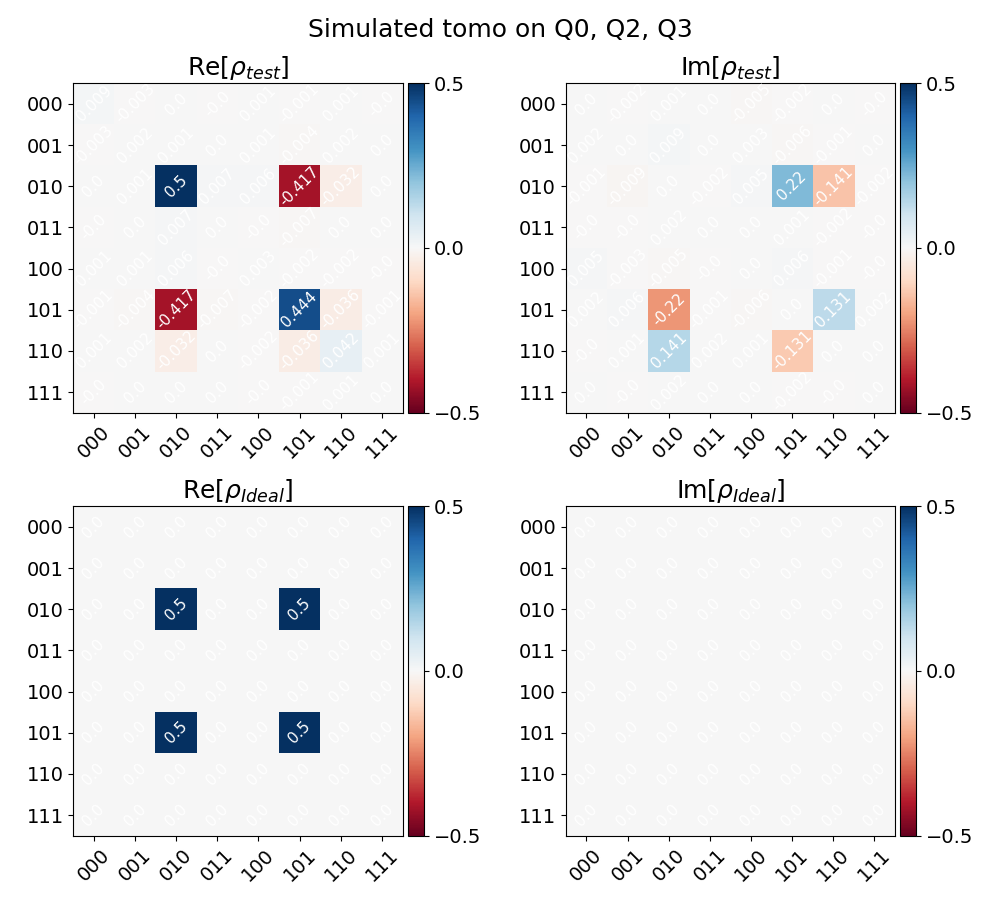

Fidelity: 0.055607522481188915
Purity (sim): 0.9727254665840565
Purity (ideal): 1.0


In [259]:
# print(result[-1].dims)
tomo_qubits = [0, 2, 3]
result3q = qt.ptrace(result[-1].unit(), tomo_qubits)
# result3q = qt.ptrace(psi0, tomo_qubits)
orig_dims = result3q.dims[0]
# result3q = qt.ptrace(result.unit(), tomo_qubits)
# print('orig dims', orig_dims)
# rho_result3q = result3q
# print(result3q)

states_inds = [i*orig_dims[0]*orig_dims[1] + j*orig_dims[1] + k for i in range(2) for j in range(2) for k in range(2)]
print('extract state indices', states_inds)
rho_result3q = result3q.extract_states(states_inds, normalize=True)


id3q = qt.tensor(qt.qeye(2), qt.qeye(2), qt.qeye(2))
rho_result3q  = qt.Qobj(rho_result3q , dims=id3q.dims, shape=id3q.shape).unit()
print(rho_result3q)

show_plot_rho_2d(rho_MLE=rho_result3q.full(), rho_id=rho_id.full(), num_tomo=3, title=f'Simulated tomo on Q{tomo_qubits[0]}, Q{tomo_qubits[1]}, Q{tomo_qubits[2]}', cmax=0.5) #, savetitle='0_0+1_simulated_flat.png') #, cmax=1.0)

fid = qt.fidelity(rho_result3q, rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
purity_sim = np.real(np.trace(rho_result3q.full() @ rho_result3q.full()))
purity_id = np.real(np.trace(rho_id.full() @ rho_id.full()))
print(f'Fidelity: {fid}')
print(f'Purity (sim): {purity_sim}')
print(f'Purity (ideal): {purity_id}')

Optimize over virtual Z

In [260]:
def z_gate_3q(phi1, phi2, phi3):
    return qt.tensor(qt.qip.operations.gates.rz(phi1), qt.qip.operations.gates.rz(phi2), qt.qip.operations.gates.rz(phi3)) 

def z_gate_3q(phi1, phi2, phi3): # expects phis in deg
    return qt.tensor(qt.qip.operations.gates.rz(np.pi/180*phi1), qt.qip.operations.gates.rz(np.pi/180*phi2), qt.qip.operations.gates.rz(np.pi/180*phi3)) 

# The experimental density matrix from MLE may be offset from the simulated/ideal density matrix by a Z gate - due to different pulse times, ac stark shifts, etc.
def opt_virtualZ_MLE(rho_test, rho_id, phis=[None, None, None]): # phis in deg
    if phis[0] is None: phis[0] = np.linspace(0, 360, 100)
    if phis[1] is None: phis[1] = np.linspace(0, 360, 100)
    if phis[2] is None: phis[2] = np.linspace(0, 360, 100)
    best_fid = 0
    best_phis = [0, 0, 0]
    best_rho_test = rho_test
    fids_grid = np.zeros((len(phis[0]), len(phis[1]), len(phis[2])))
    for i, phi1 in enumerate(tqdm(phis[0])):
        for j, phi2 in enumerate(phis[1]):
            for k, phi3 in enumerate(phis[2]):
                z_phi123 = z_gate_3q(phi1, phi2, phi3)
                rho_test_rot = (z_phi123*rho_test*z_phi123.dag()).unit()
                fid = qt.fidelity(rho_test_rot, rho_id)**2
                fids_grid[i, j, k] = fid
                # print(fid)
                if fid > best_fid:
                    best_fid = fid
                    best_phis = [phi1, phi2, phi3]
                    best_rho_test = rho_test_rot
    print(f'Improved fidelity by (%) {(best_fid - qt.fidelity(rho_test, rho_id)**2)*100}')
    return best_rho_test, best_phis, best_fid, fids_grid

In [261]:
phis = [None, None, None]

# phis[0] = np.linspace(0, 360, 1)
phis[0] = np.linspace(0, 360, 30)
phis[1] = np.linspace(0, 360, 30)
phis[2] = np.linspace(0, 360, 30)

rho_3q_rot, best_phis, best_fid, fids_grid = opt_virtualZ_MLE(qt.Qobj(rho_result3q, dims=rho_id.dims), rho_id, phis=phis)
print('Rotation:', best_phis)

100%|██████████| 30/30 [00:44<00:00,  1.49s/it]

Improved fidelity by (%) 88.6988446762103
Rotation: [173.79310344827587, 297.9310344827586, 273.1034482758621]


phi Q0 0.0


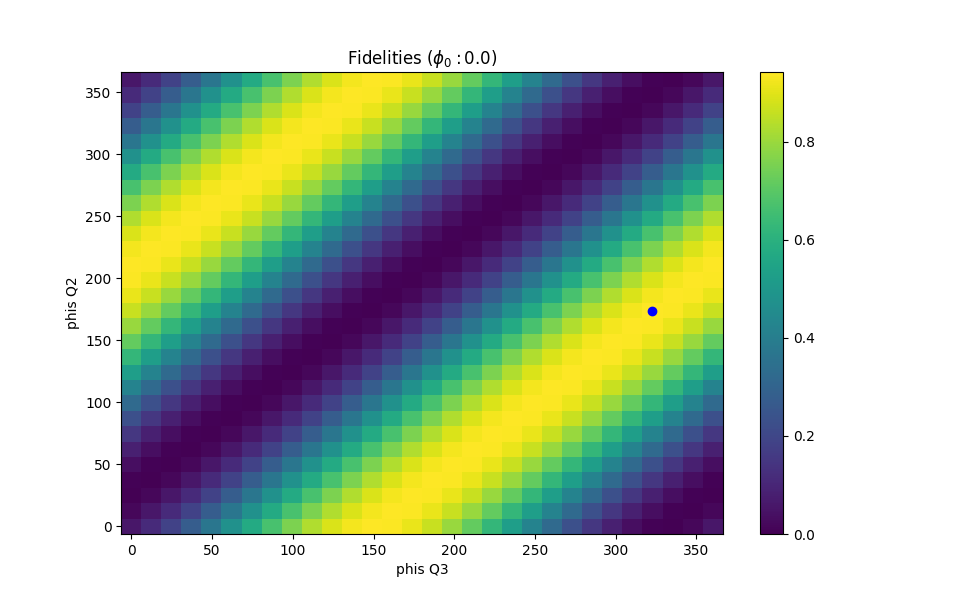

phi Q0 12.413793103448276


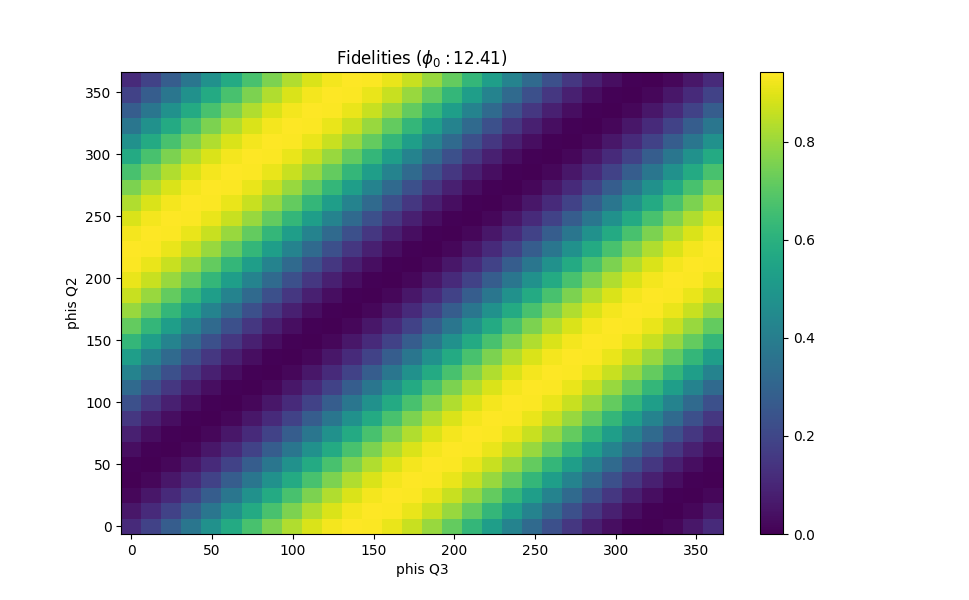

phi Q0 24.82758620689655


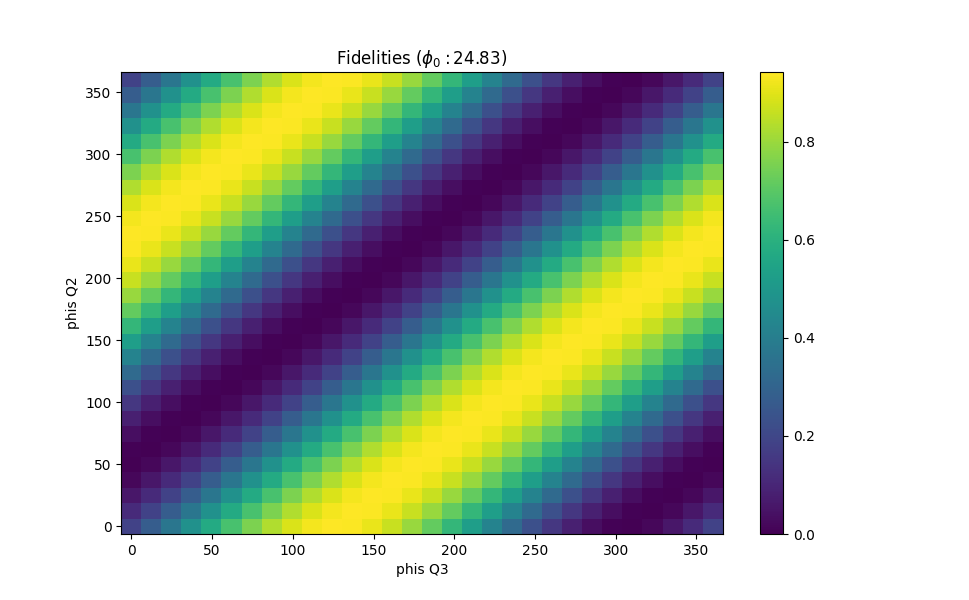

phi Q0 37.241379310344826


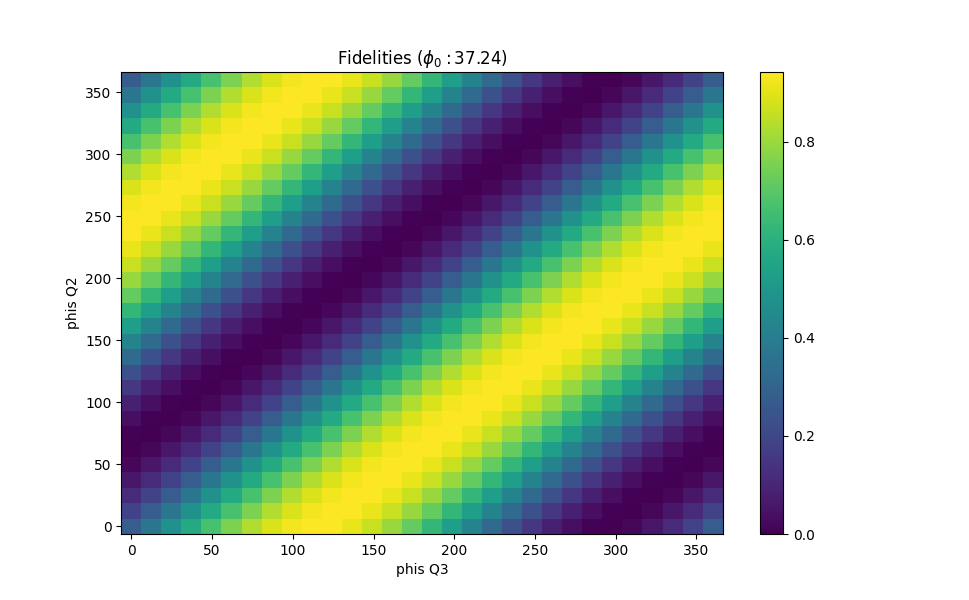

phi Q0 49.6551724137931


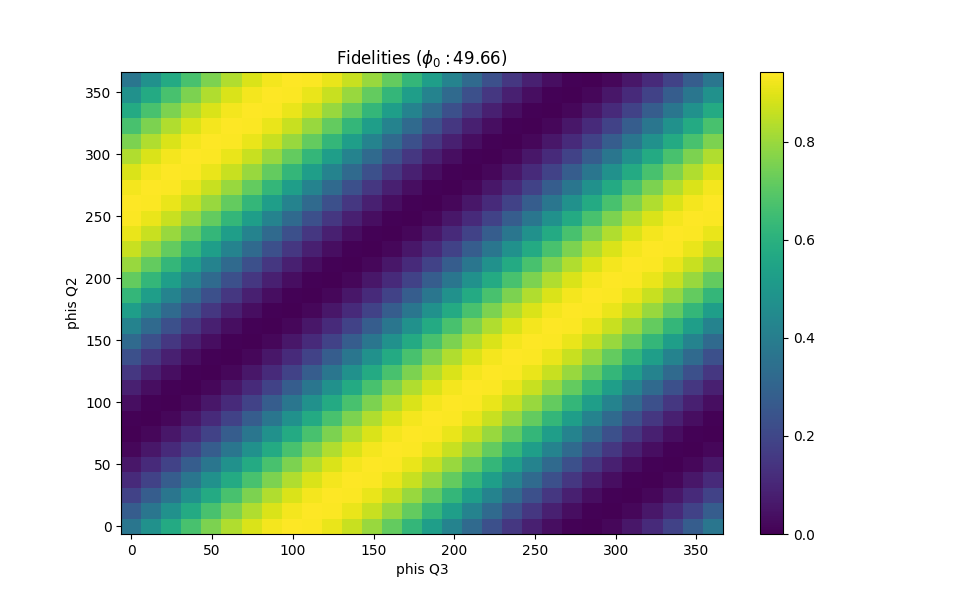

phi Q0 62.06896551724138


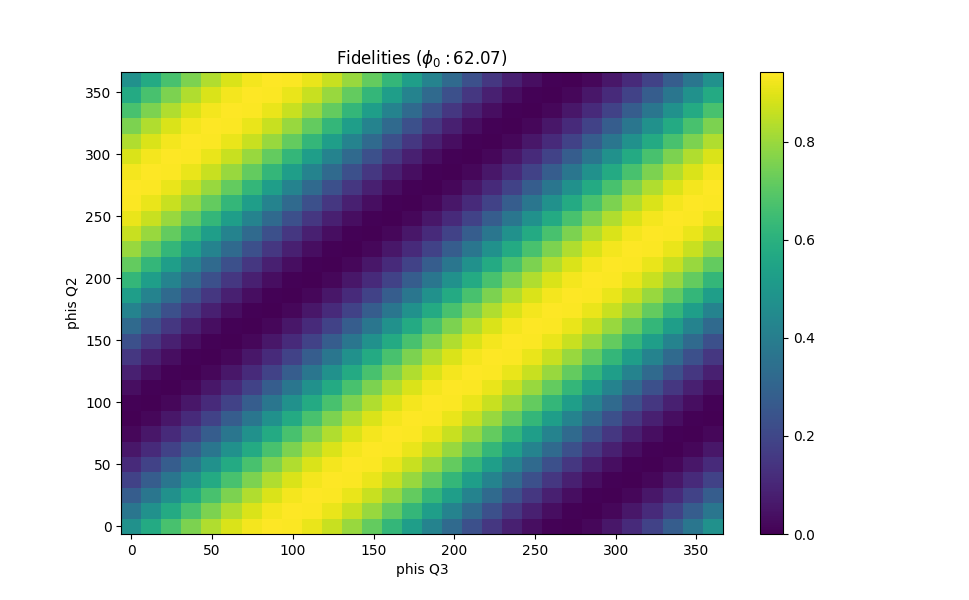

phi Q0 74.48275862068965


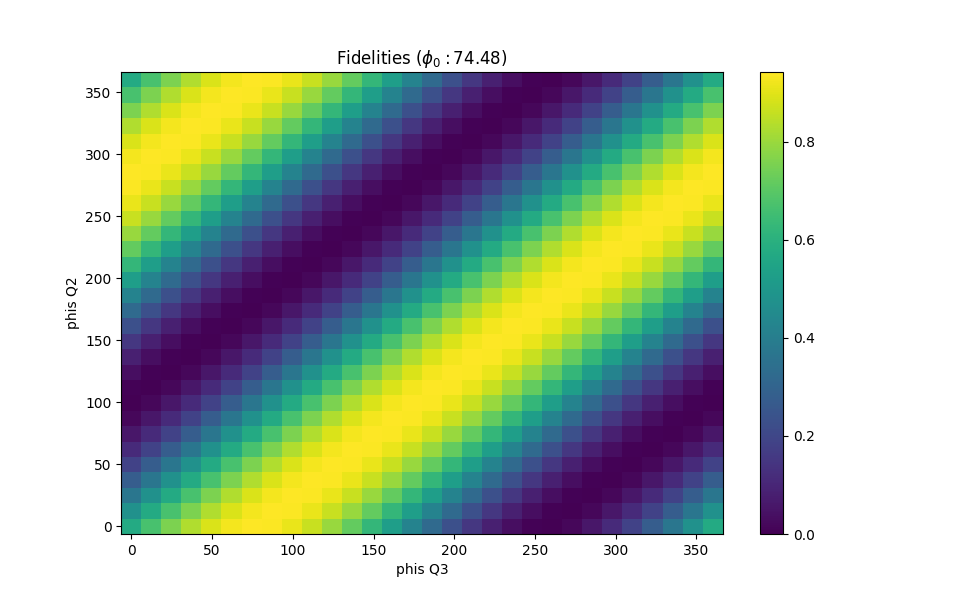

phi Q0 86.89655172413794


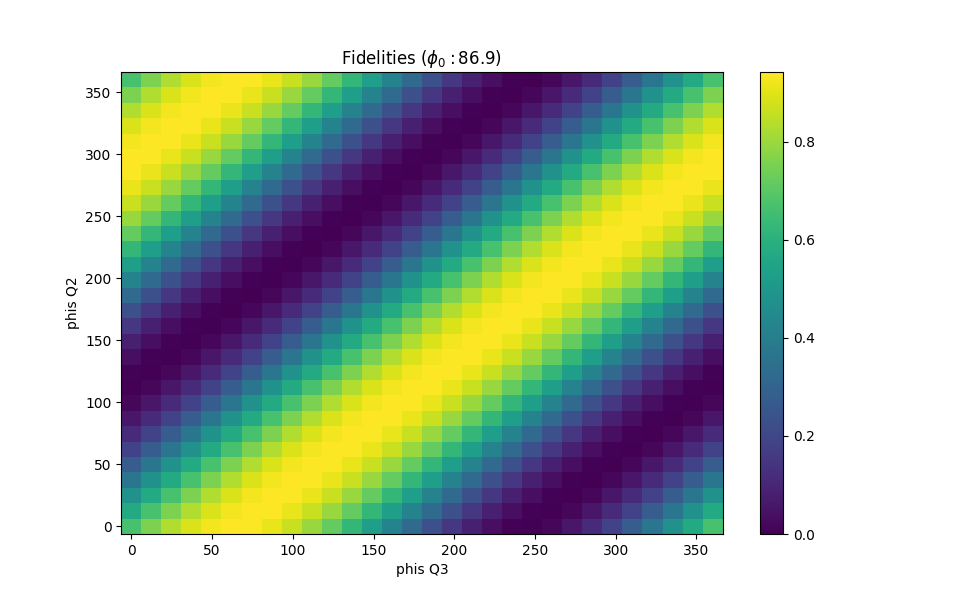

phi Q0 99.3103448275862


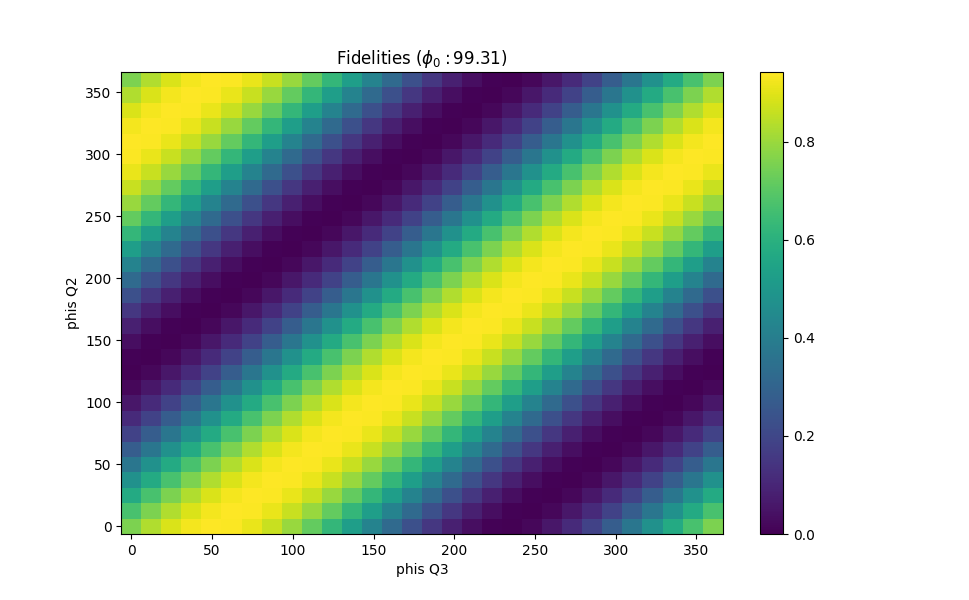

phi Q0 111.72413793103448


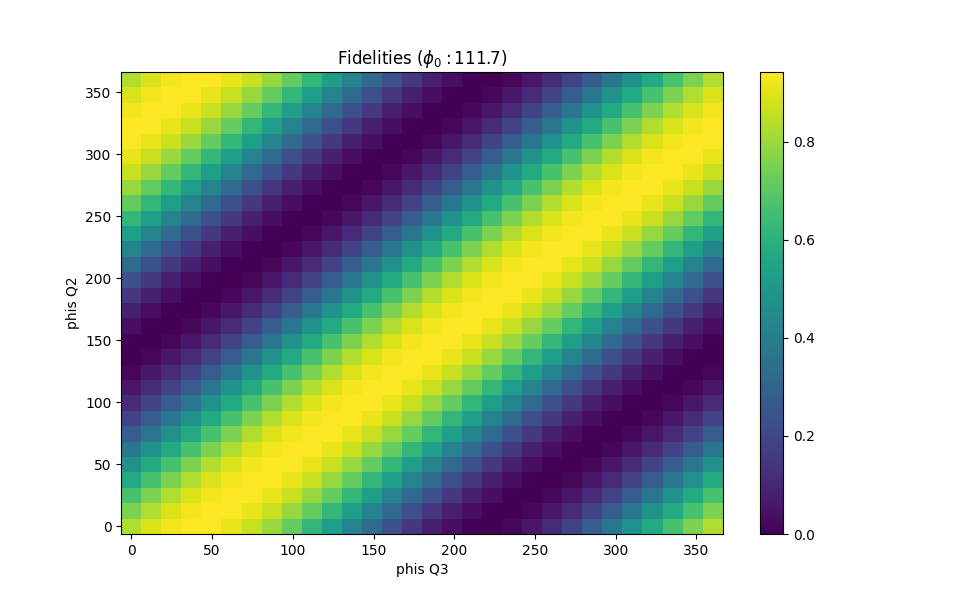

phi Q0 124.13793103448276


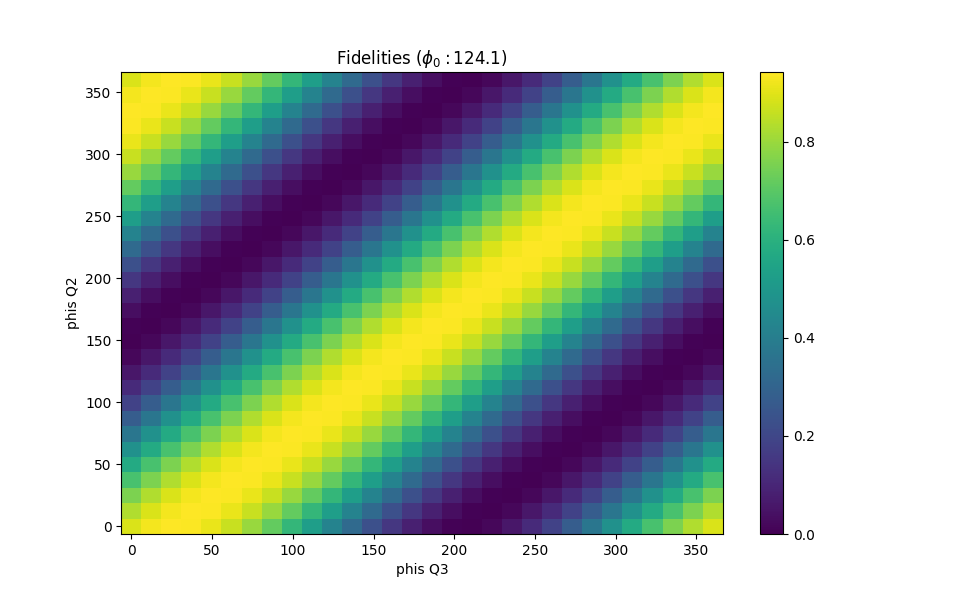

phi Q0 136.55172413793105


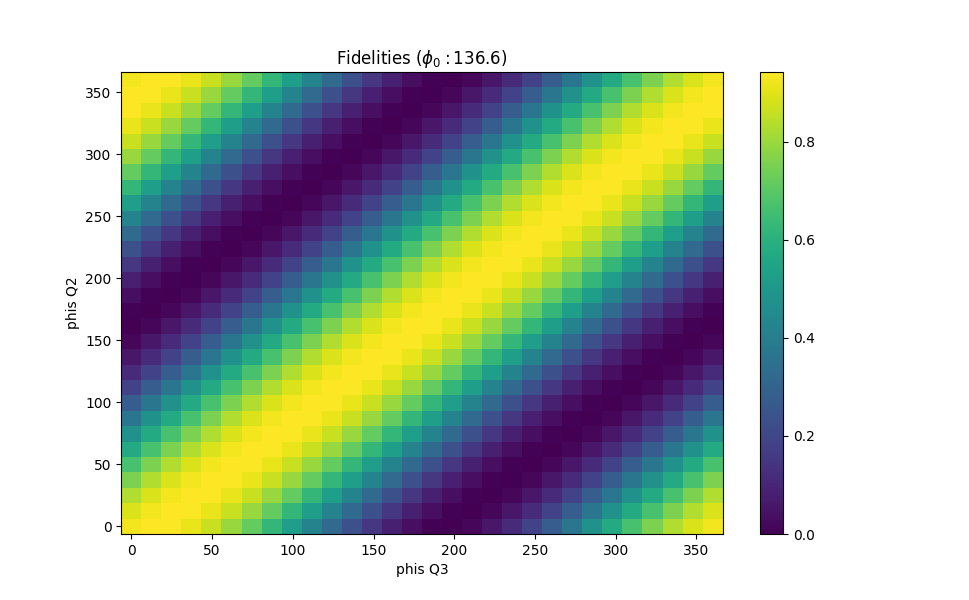

phi Q0 148.9655172413793


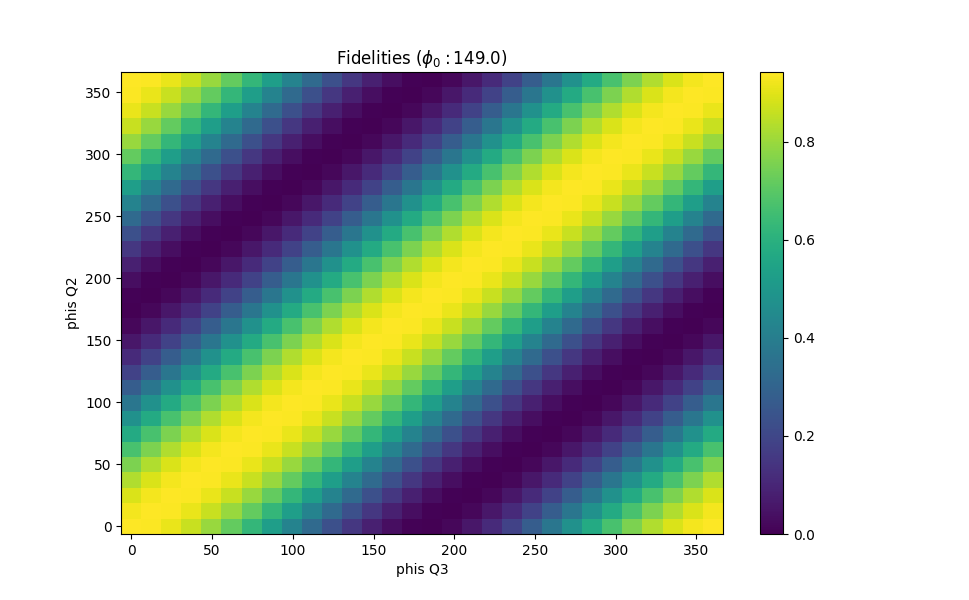

phi Q0 161.3793103448276


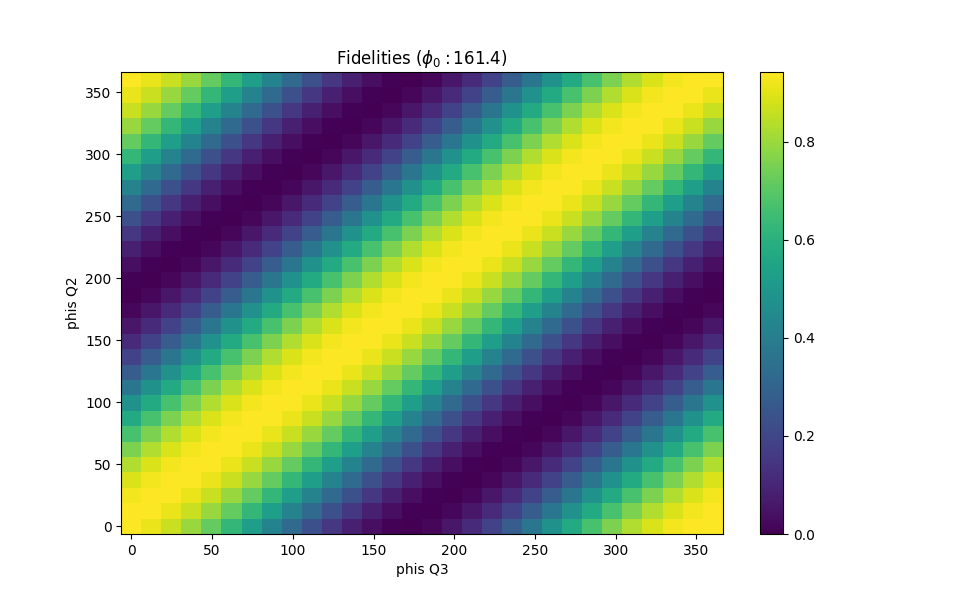

phi Q0 173.79310344827587


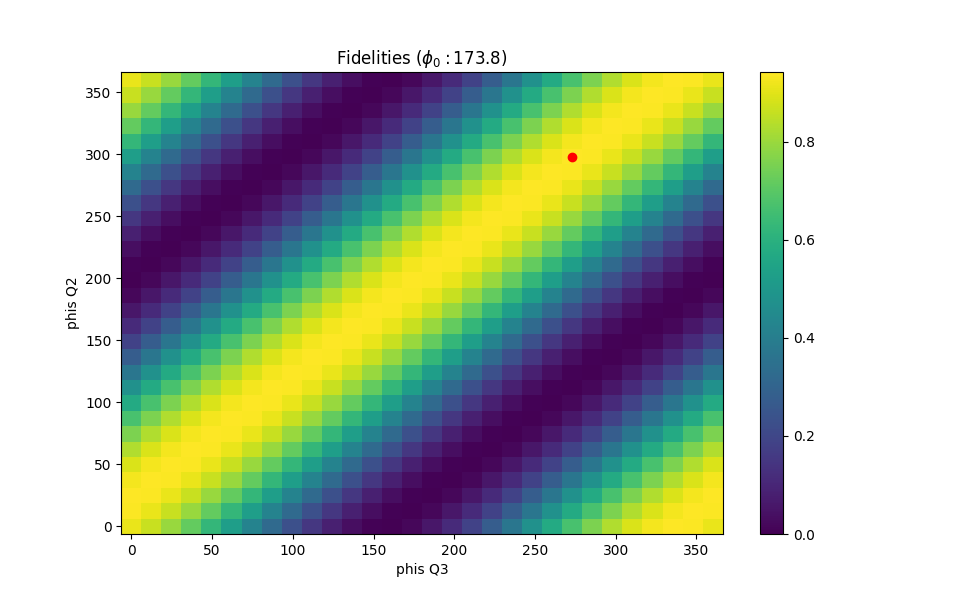

phi Q0 186.20689655172413


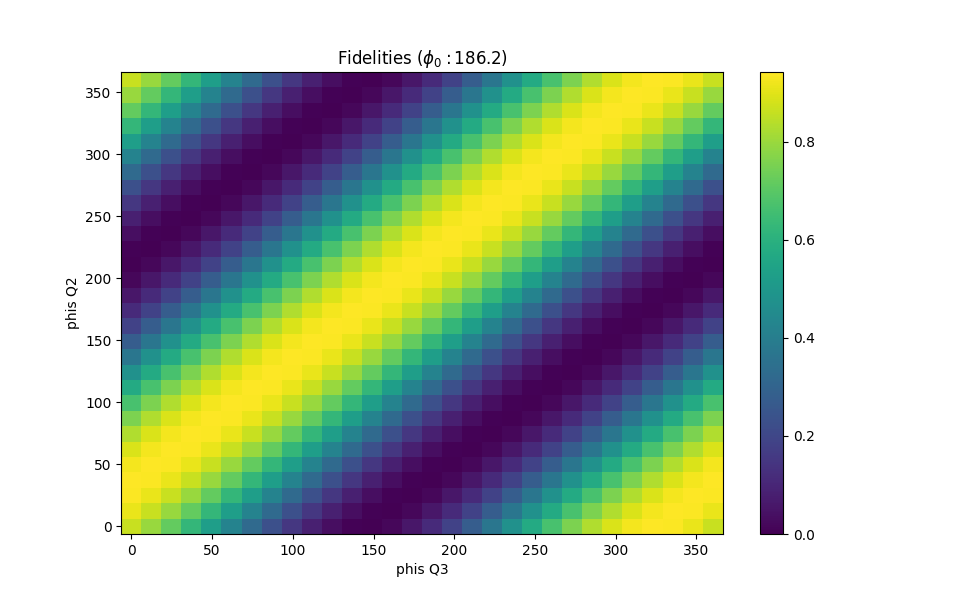

phi Q0 198.6206896551724


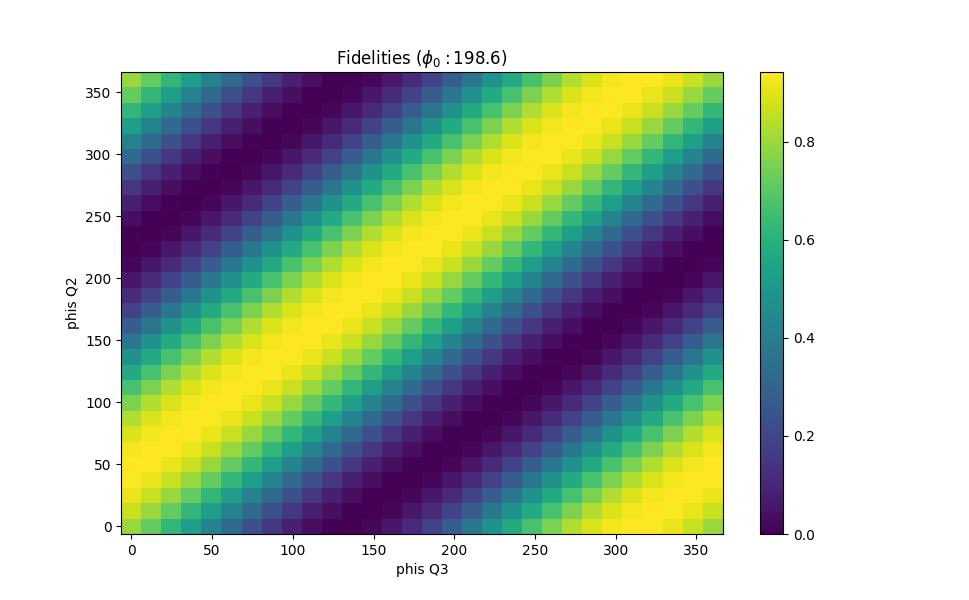

phi Q0 211.0344827586207


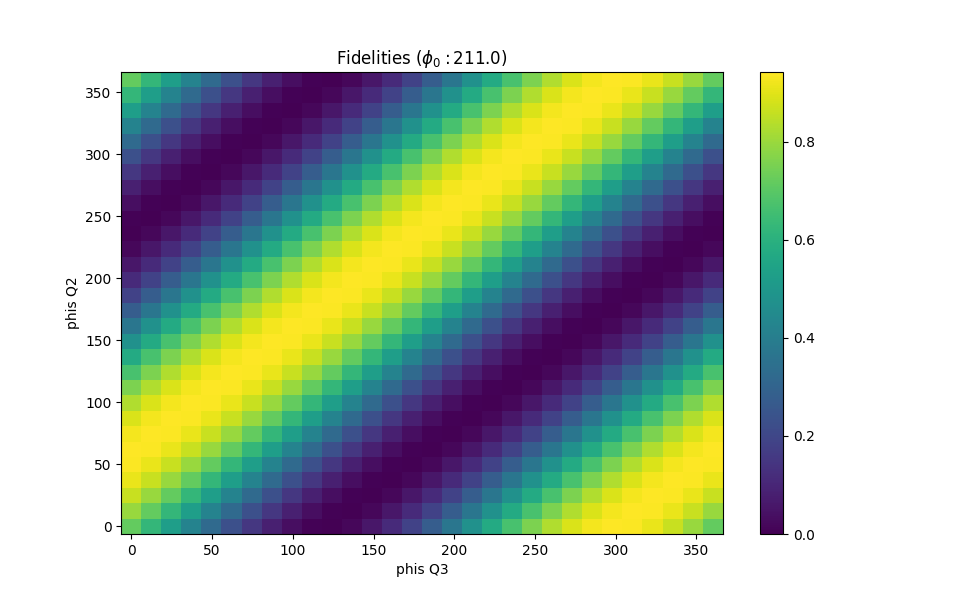

phi Q0 223.44827586206895


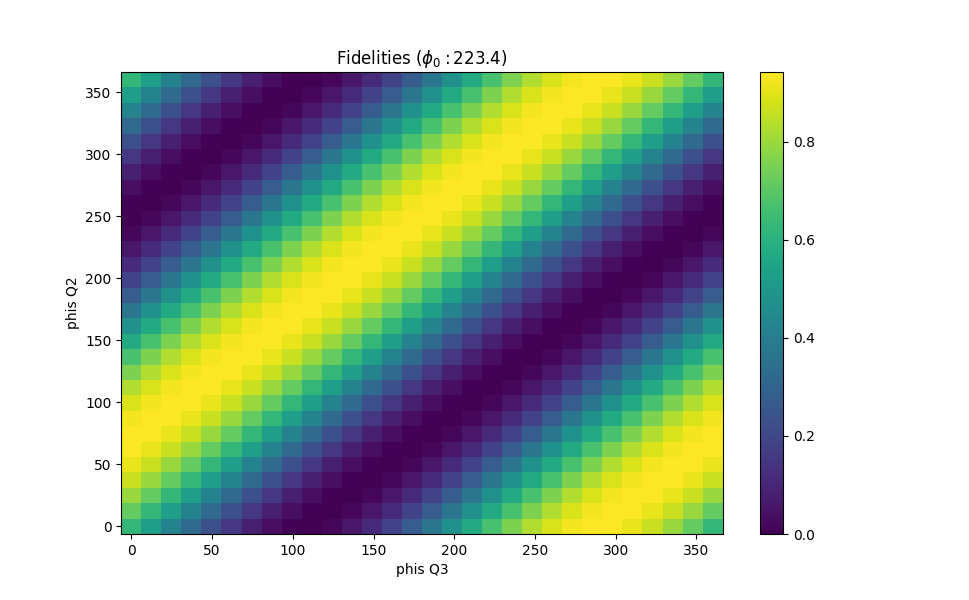

phi Q0 235.86206896551724


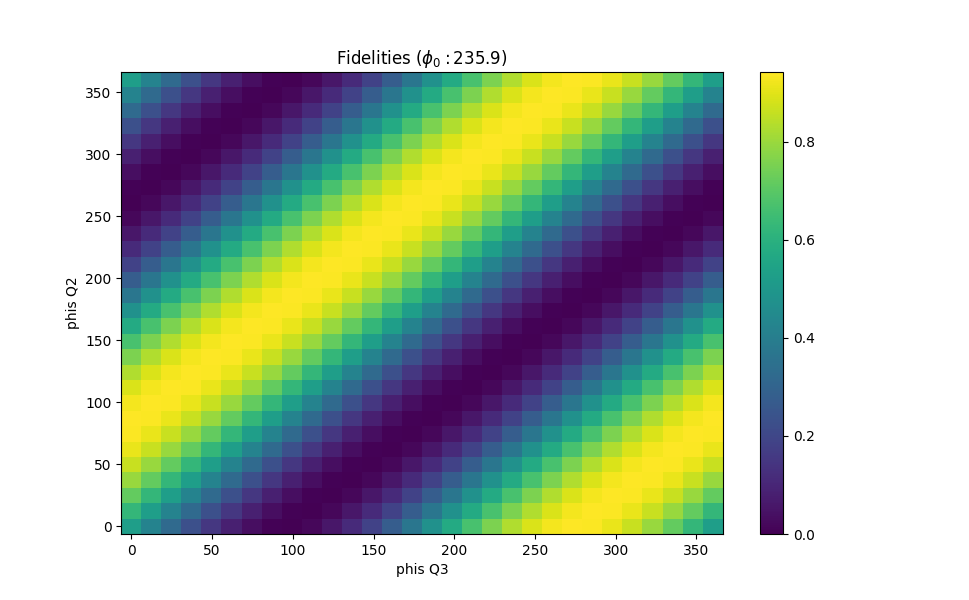

phi Q0 248.27586206896552


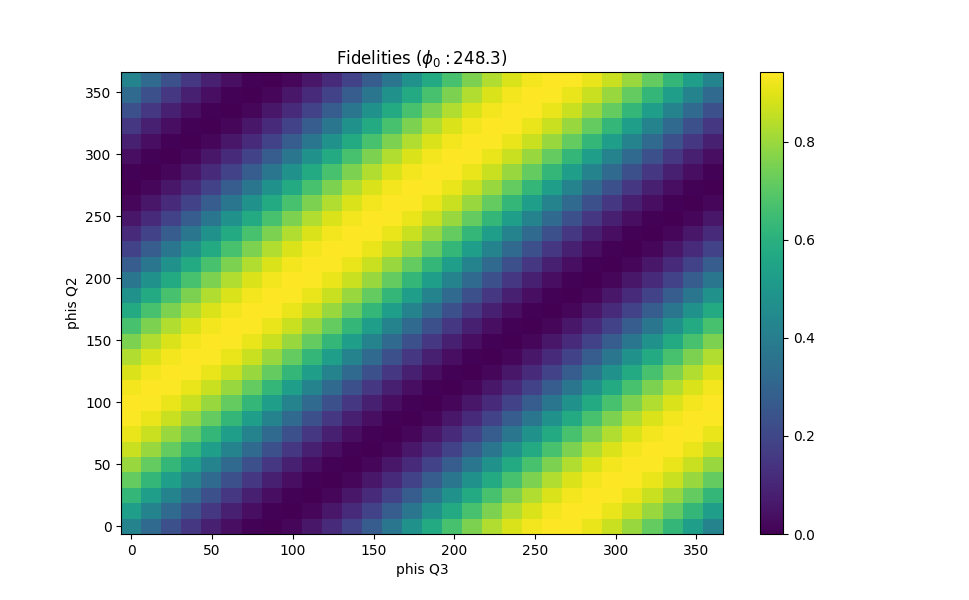

phi Q0 260.6896551724138


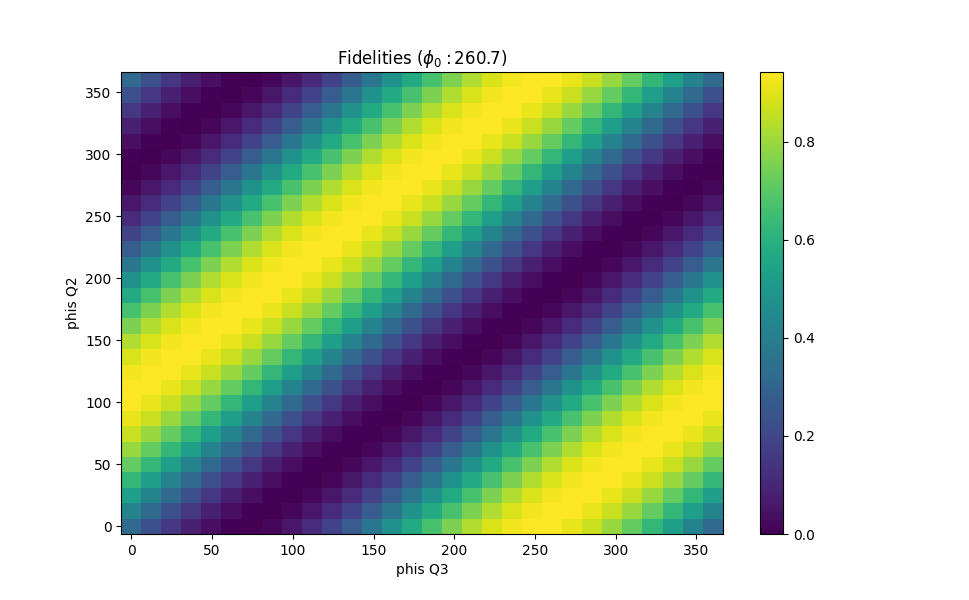

phi Q0 273.1034482758621


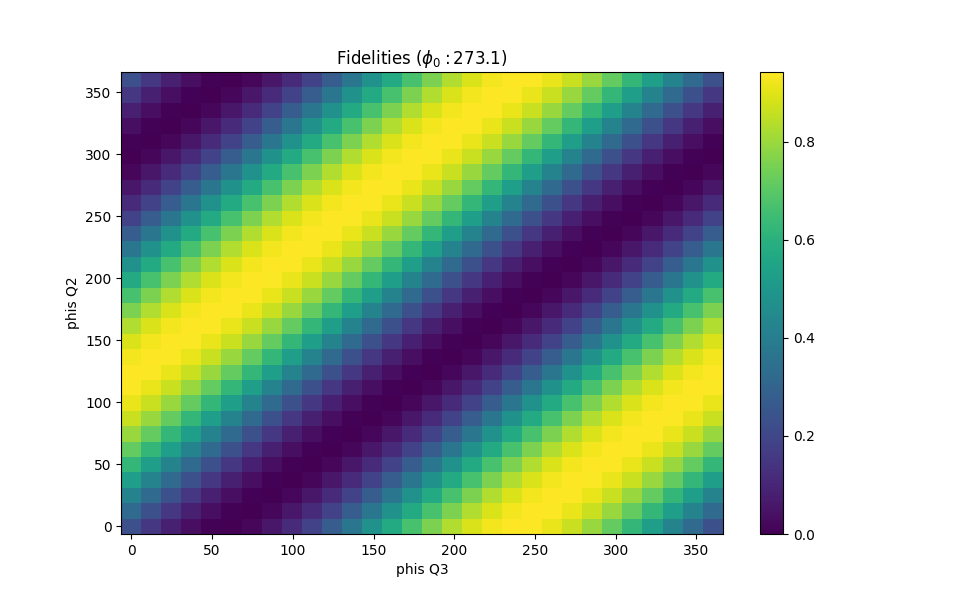

phi Q0 285.51724137931035


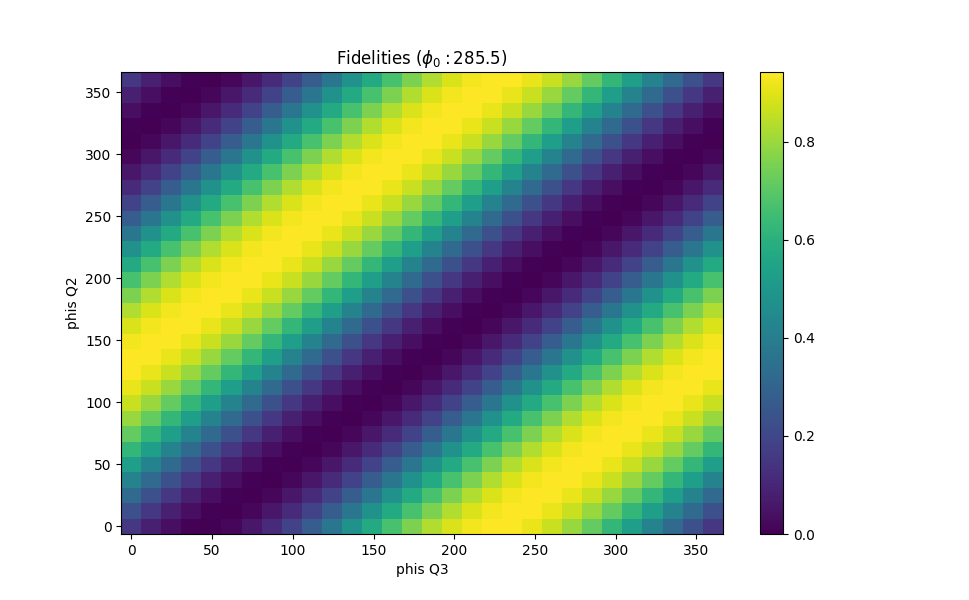

phi Q0 297.9310344827586


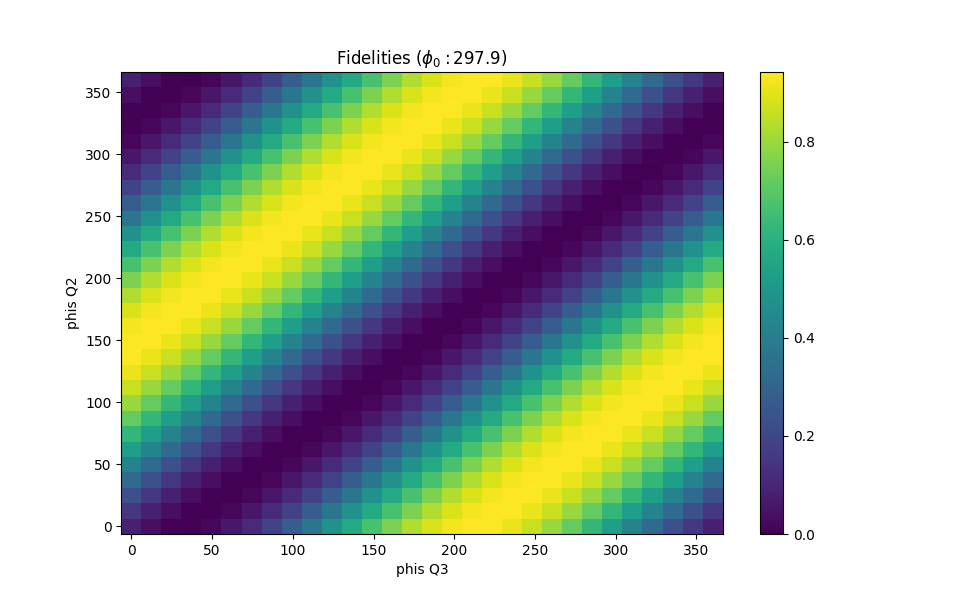

phi Q0 310.3448275862069


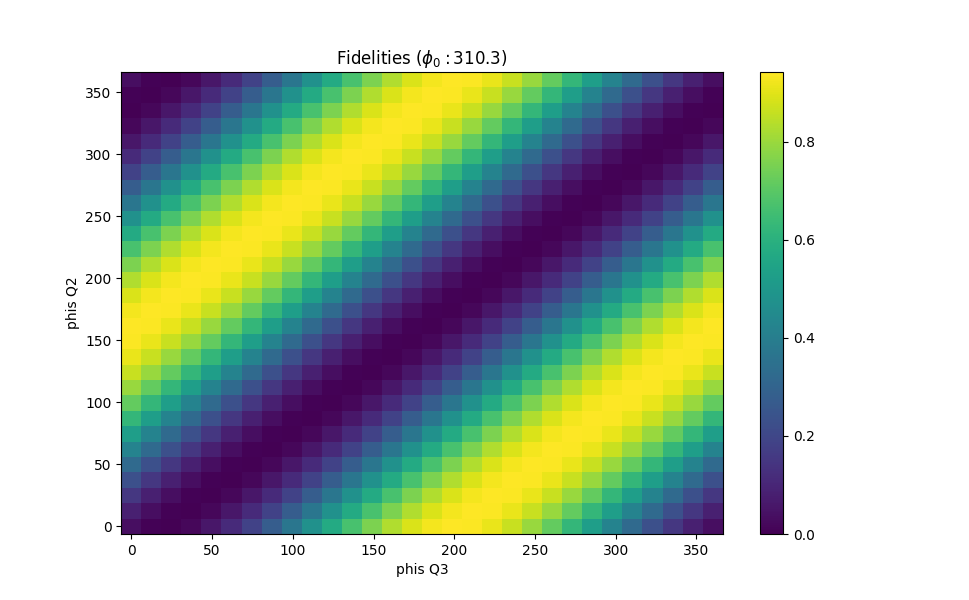

phi Q0 322.7586206896552


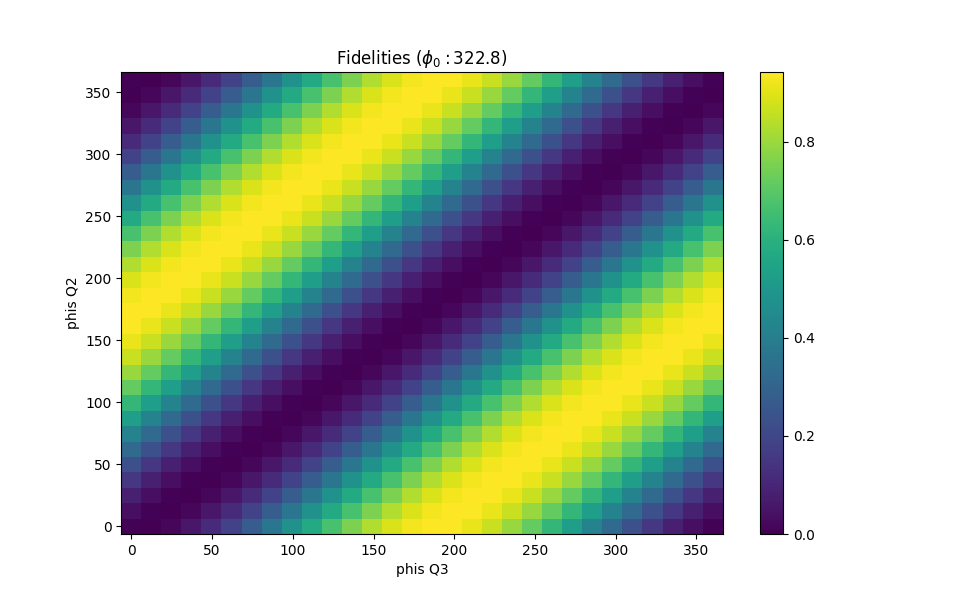

phi Q0 335.17241379310343


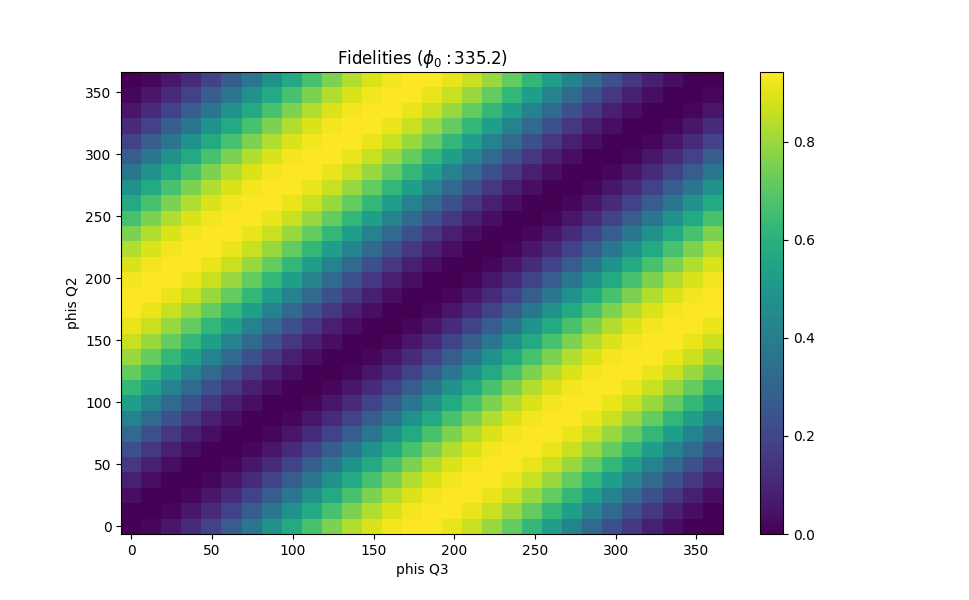

phi Q0 347.58620689655174


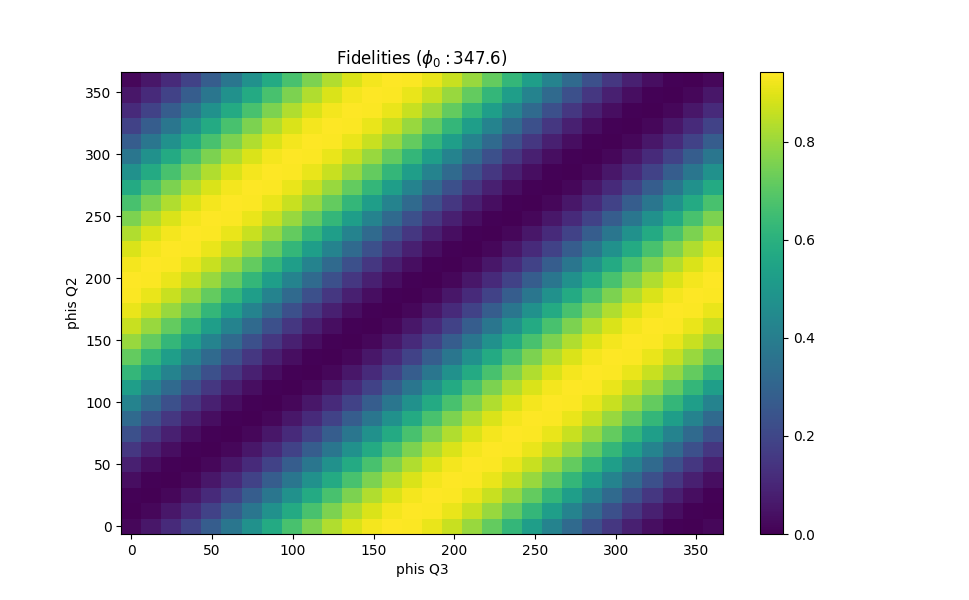

phi Q0 360.0


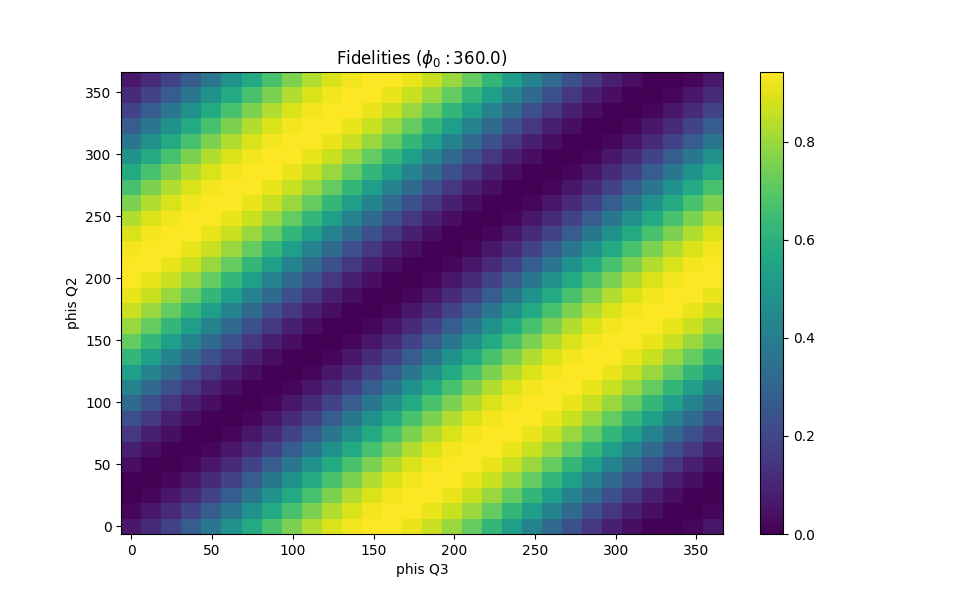

In [262]:
inner_sweep = phis[2]
outer_sweep = phis[1]
y_sweep = outer_sweep
x_sweep = inner_sweep

vmax = np.max(fids_grid)

for i_phi0, phi0 in enumerate(phis[0]):
    print(f'phi Q0 {phi0}')
    # if i_phi0 > 20: break
    plt.figure()
    plt.title(f'Fidelities ($\phi_0: ${phi0:0.4})')
    plt.xlabel(f'phis Q{tomo_qubits[2]}')
    plt.ylabel(f'phis Q{tomo_qubits[1]}')
    plt.pcolormesh(y_sweep, x_sweep, fids_grid[i_phi0], cmap='viridis', shading='auto')
    
    if phi0 == best_phis[0]: plt.plot([best_phis[2]], [best_phis[1]], 'r', marker='o')
    
    old_best_phis = [0.0, 173.79310344827587, 322.7586206896552]
    # old_best_phis = [0.0, 196.36363636363635, 341.8181818181818]
    # plt.plot([old_best_phis[2]], [old_best_phis[1]], 'r', marker='o')
    if phi0 == old_best_phis[0]: plt.plot([old_best_phis[2]], [old_best_phis[1]], 'b', marker='o')
    
    plt.colorbar()
    # plt.clim(vmin=0, vmax=1)
    plt.clim(vmin=0, vmax=vmax)
    plt.show()

Fidelity (after rotation): 0.055607522481188915
Purity (after rotation): 0.9727254665840565
Target purity: 1.0
Best rotation: [173.79310344827587, 297.9310344827586, 273.1034482758621]


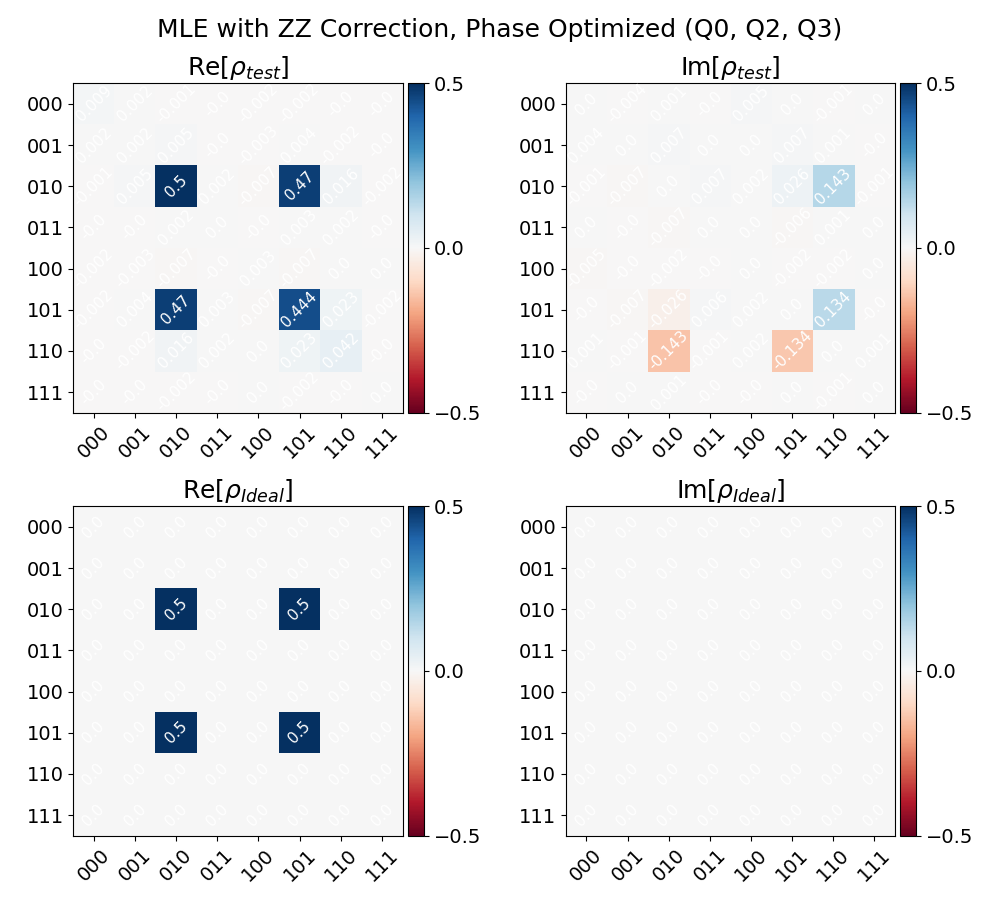

In [263]:
z_phi123 = z_gate_3q(*best_phis)
rho_result3q_rot = (z_phi123*qt.Qobj(rho_result3q, dims=rho_id.dims)*z_phi123.dag()).unit()
fid_rot = qt.fidelity(rho_result3q_rot, rho_id)**2

fid = qt.fidelity(rho_result3q, rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
purity_sim = np.real(np.trace(rho_result3q.full() @ rho_result3q.full()))
purity_id = np.real(np.trace(rho_id.full() @ rho_id.full()))
print(f'Fidelity (after rotation): {fid}')
print(f'Purity (after rotation): {purity_sim}')
print(f'Target purity: {purity_id}')
print(f'Best rotation: {best_phis}')


# print(np.around(rho_result3q_rot, decimals=3))
savetitle=None
show_plot_rho_2d(rho_result3q_rot, rho_id, num_tomo=3, title=f'MLE with ZZ Correction, Phase Optimized (Q{tomo_qubits[0]}, Q{tomo_qubits[1]}, Q{tomo_qubits[2]})', savetitle=savetitle, cmax=0.5)

## Simulation iteration things

Iterate over pulse detuning

(adiabatic pulse)

3.4556657887229973 3.4256657887229975 3.485665788722997


100%|██████████| 100/100 [1:22:29<00:00, 49.50s/it]


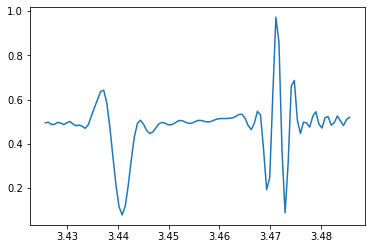

In [ ]:
wd_span = 0.060*2*np.pi # GHz
npts = 100

wd = qram.get_base_wd('gggg', 'gegg')
print(wd/2/np.pi, (wd-wd_span/2)/2/np.pi, (wd+wd_span/2)/2/np.pi)
wd_sweep = np.linspace(wd-wd_span/2, wd+wd_span/2, npts)
psi0 = (qram.state('gggg') + qram.state('gegg')).unit() # QRAM start |0>|0+1>
gegg = qram.state('gegg')
eegg = qram.state('eegg')
geeg = qram.state('geeg')
gege = qram.state('gege')
probs_q1e = []
for wd in tqdm(wd_sweep):
    seq = PulseSequence(start_time=0)
    qram.add_precise_pi_pulse(seq, 'gggg', 'gegg', amp=0.015, mu=6, beta=4, drive_qubit=1, type='adiabatic', phase=0, t_pulse=120*4, wd=wd)
    times = np.linspace(0, sum(seq.get_pulse_lengths()), 30)
    result = qram.evolve(psi0, seq, times, c_ops=None, nsteps=50000, use_str_solve=False, progress=False)[-1]
    prob_q1e = np.abs(gegg.overlap(result))**2 + np.abs(eegg.overlap(result))**2 + np.abs(geeg.overlap(result))**2 + np.abs(gege.overlap(result))**2
    probs_q1e.append(prob_q1e)
plt.plot(wd_sweep/2/np.pi, probs_q1e)
plt.show()

(IQ pulse)

In [ ]:
wd = qram.get_base_wd('gggg', 'gegg')
detunings = np.linspace(0, 5e-3, num=25)
gggg = qram.state('gggg')
gegg = qram.state('gegg')
psi0 = (gggg + gegg).unit()
phases = []
for idet, detune in enumerate(tqdm(detunings)):
    seq = PulseSequence(start_time=0)
    seq.pulse_IQ(wd=wd + 2*np.pi*detune, amp=1, pulse_levels=('gggg', 'gegg'), I_values=controls[1], Q_values=-controls[0], times=control_times, drive_qubit=1, t_start=0, phase=0)
    times = np.linspace(0, sum(seq.get_pulse_lengths()), 50)
    result = qram.evolve(psi0, seq, times, c_ops=None, nsteps=20000, use_str_solve=False, progress=False)
    psif = result[-1]
    phase = psif.overlap(gegg) / psif.overlap(gggg)
    phase /= abs(phase)
    try: phase = np.arctan(np.imag(phase) / np.real(phase))
    except ZeroDivisionError: phase = np.pi/2
    if idet == 0:
        phase0 = phase
        print('phase 0:', phase0)
    phase -= phase0
    phases.append(phase)

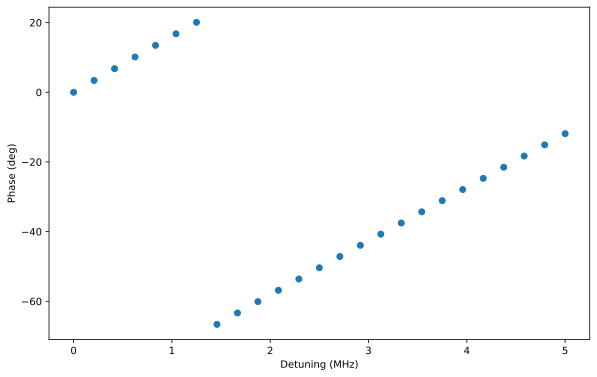

In [ ]:
plt.plot(detunings*1e3, np.array(phases)/2/np.pi*180, 'o')
plt.ylabel('Phase (deg)')
plt.xlabel('Detuning (MHz)')
plt.show()

Iterate over 2q swap params

In [ ]:
wd = qram.get_base_wd('gggg', 'gegg')
IQscale = max(np.max(np.abs(controls_q[0])), np.max(np.abs(controls_q[1])))
amps = np.linspace(0, 2*IQscale, num=100)
gggg = qram.state('gggg')
gegg = qram.state('gegg')
# psi0 = (gggg + gegg).unit()
psi0 = gggg
plot_states = ['eggg', 'gfgg', 'ggeg', 'eegg', 'ggge', 'geeg', 'gege', 'gggg', 'gegg', 'efgg'] #, 'ehgg', 'ghgg']
results_amps = []
for iamp, amp in enumerate(tqdm(amps)):
    seq = PulseSequence(start_time=0)
    seq.pulse_IQ(wd=wd, amp=amp, pulse_levels=('gggg', 'gegg'), I_values=controls[1]/IQscale, Q_values=-controls[0]/IQscale, times=control_times, drive_qubit=1, t_start=0, phase=0)
    # times = np.linspace(control_times[0], control_times[-1], 50)
    times = control_times
    result = qt.mesolve(qram.H_solver_rot_wd(seq=seq, wframe=qram.get_base_wd('gggg', 'gegg')), psi0, times, progress_bar=None, options=qt.Options(nsteps=1000)).states
    results_amps.append(result[-1])

prob_states = dict()
for state in plot_states:
    psi = qram.state(state)
    prob_states.update({state:[np.abs(psi.overlap(results_amps[i_amp]))**2 for i_amp in range(len(amps))]})

for state in plot_states:
    plt.plot(amps*1e3, prob_states[state], label=rf'$|{state}\rangle_D$')

plt.legend(fontsize=10, ncol=2)
plt.ylim(0, 1)
# plt.xlim(750, 1000)
plt.tick_params(labelsize=14)
plt.xlabel('Amps (MHz)', fontsize=14)
plt.ylabel('Probability', fontsize=14)
# plt.title(r'$\psi_0=|$'+psi0_name+r'$\rangle$')
# plt.title('QRAM state evolution in memory access operation')
plt.grid(linewidth=0.3)

Iterate over pulse amplitude

In [270]:
amps = np.linspace(0.050, 0.250, num=25)
psi0 = (qram.state('gegg') + qram.state('eegg')).unit() # QRAM start |0+1>|1>
plot_states = ['gggg', 'eggg', 'eegg', 'gegg', 'ggfg', 'eggf', 'egfg', 'gggf', 'ggeg', 'egge']
results_amps = []
for iamp, amp in enumerate(tqdm(amps)):
    seq = PulseSequence(start_time=0)

    w_swap_12 = qram.get_wd('gegg', 'ggfg', amp=amp, drive_qubit=2, verbose=False)
    wd0 = qram.add_sequential_pi_pulse(seq, 'gegg', 'ggfg', amp=amp, drive_qubit=2, phase=phase_IS, wd=w_swap_12, type='flat_top', t_rise=1)

    # result_lab = qram.evolve(psi0, seq, times, c_ops=None, nsteps=20000, use_str_solve=False)
    # result = qram.evolve_unrotate(times=[times[-1]], result=[result_lab[-1]])

    result = qt.mesolve(qram.H_solver_rot_wd(seq=seq, wframe=w_swap_12), psi0, times, progress_bar=None, options=qt.Options(nsteps=1000)).states
    results_amps.append(result[-1])


  0%|          | 0/25 [00:00<?, ?it/s]

	new overlap 0.9239869596279107 wd 37.108120632604354 wd_res 0.25
	new overlap 0.9239869596279107 wd 37.108120632604354 wd_res 0.05
	new overlap 0.9239869596279107 wd 37.108120632604354 wd_res 0.005
	new overlap 0.9986247393887477 wd 37.106620632604354 wd_res 0.0005
updated drive freq (GHz) from 5.905940827529333 to 5.9057020951146955


  4%|▍         | 1/25 [00:20<08:08, 20.34s/it]

	new overlap 0.9037495713678535 wd 37.108120632604354 wd_res 0.25
	new overlap 0.9037495713678535 wd 37.108120632604354 wd_res 0.05
	new overlap 0.9037495713678535 wd 37.108120632604354 wd_res 0.005
	new overlap 0.9977504632438352 wd 37.10612063260435 wd_res 0.0005
updated drive freq (GHz) from 5.905940827529333 to 5.905622517643149


  8%|▊         | 2/25 [00:41<07:58, 20.78s/it]

	new overlap 0.8835009563846955 wd 37.108120632604354 wd_res 0.25
	new overlap 0.8835009563846955 wd 37.108120632604354 wd_res 0.05
	new overlap 0.9225747603674583 wd 37.10312063260435 wd_res 0.005
	new overlap 0.9977487084687939 wd 37.105120632604354 wd_res 0.001
updated drive freq (GHz) from 5.905940827529333 to 5.905463362700058


 12%|█▏        | 3/25 [01:01<07:34, 20.66s/it]

	new overlap 0.863696408132353 wd 37.108120632604354 wd_res 0.25
	new overlap 0.863696408132353 wd 37.108120632604354 wd_res 0.05
	new overlap 0.9685670529338637 wd 37.10312063260435 wd_res 0.005
	new overlap 0.9952688396095124 wd 37.10412063260435 wd_res 0.001
updated drive freq (GHz) from 5.905940827529333 to 5.905304207756965


 16%|█▌        | 4/25 [01:23<07:18, 20.89s/it]

	new overlap 0.8446350779655719 wd 37.108120632604354 wd_res 0.25
	new overlap 0.8446350779655719 wd 37.108120632604354 wd_res 0.05
	new overlap 0.9934321440827277 wd 37.10312063260435 wd_res 0.005
updated drive freq (GHz) from 5.905940827529333 to 5.905145052813873


 20%|██        | 5/25 [01:42<06:43, 20.16s/it]

	new overlap 0.8264939412898342 wd 37.108120632604354 wd_res 0.25
	new overlap 0.8264939412898342 wd 37.108120632604354 wd_res 0.05
	new overlap 0.9947644576294855 wd 37.10312063260435 wd_res 0.005
updated drive freq (GHz) from 5.905940827529333 to 5.905145052813873


 24%|██▍       | 6/25 [02:00<06:13, 19.66s/it]

	new overlap 0.8093604496844911 wd 37.108120632604354 wd_res 0.25
	new overlap 0.8093604496844911 wd 37.108120632604354 wd_res 0.05
	new overlap 0.9774822827640048 wd 37.10312063260435 wd_res 0.005
	new overlap 0.9941085537495358 wd 37.102120632604354 wd_res 0.001
updated drive freq (GHz) from 5.905940827529333 to 5.904985897870782


 28%|██▊       | 7/25 [02:22<06:04, 20.25s/it]

	new overlap 0.7932599409987329 wd 37.108120632604354 wd_res 0.25
	new overlap 0.7932599409987329 wd 37.108120632604354 wd_res 0.05
	new overlap 0.954786794687446 wd 37.098120632604356 wd_res 0.005
	new overlap 0.9939592274675846 wd 37.10012063260436 wd_res 0.001
updated drive freq (GHz) from 5.905940827529333 to 5.904667587984599


 32%|███▏      | 8/25 [02:42<05:47, 20.42s/it]

	new overlap 0.7781768516850667 wd 37.108120632604354 wd_res 0.25
	new overlap 0.7781768516850667 wd 37.108120632604354 wd_res 0.05
	new overlap 0.9852881624062744 wd 37.098120632604356 wd_res 0.005
	new overlap 0.9943288134300319 wd 37.099120632604354 wd_res 0.001
updated drive freq (GHz) from 5.905940827529333 to 5.9045084330415065


 36%|███▌      | 9/25 [03:03<05:25, 20.32s/it]

	new overlap 0.7640702498604959 wd 37.108120632604354 wd_res 0.25
	new overlap 0.7640702498604959 wd 37.108120632604354 wd_res 0.05
	new overlap 0.9936345721325562 wd 37.098120632604356 wd_res 0.005
updated drive freq (GHz) from 5.905940827529333 to 5.904349278098414


 40%|████      | 10/25 [03:21<04:54, 19.66s/it]

	new overlap 0.750884746763663 wd 37.108120632604354 wd_res 0.25
	new overlap 0.750884746763663 wd 37.108120632604354 wd_res 0.05
	new overlap 0.9806137976264522 wd 37.098120632604356 wd_res 0.005
	new overlap 0.99192951525886 wd 37.096120632604354 wd_res 0.001
updated drive freq (GHz) from 5.905940827529333 to 5.904030968212231


 44%|████▍     | 11/25 [03:41<04:38, 19.90s/it]

	new overlap 0.7385578985156527 wd 37.108120632604354 wd_res 0.25
	new overlap 0.7385578985156527 wd 37.108120632604354 wd_res 0.05
	new overlap 0.976051857098581 wd 37.093120632604354 wd_res 0.005
	new overlap 0.9919503787811185 wd 37.095120632604356 wd_res 0.001
updated drive freq (GHz) from 5.905940827529333 to 5.903871813269139


 48%|████▊     | 12/25 [04:04<04:28, 20.63s/it]

	new overlap 0.7270250605683389 wd 37.108120632604354 wd_res 0.25
	new overlap 0.7270250605683389 wd 37.108120632604354 wd_res 0.05
	new overlap 0.990689361260634 wd 37.093120632604354 wd_res 0.005
updated drive freq (GHz) from 5.905940827529333 to 5.9035535033829545


 52%|█████▏    | 13/25 [04:23<04:02, 20.23s/it]

	new overlap 0.7162224522457112 wd 37.108120632604354 wd_res 0.25
	new overlap 0.7162224522457112 wd 37.108120632604354 wd_res 0.05
	new overlap 0.9825926041996108 wd 37.093120632604354 wd_res 0.005
	new overlap 0.9892987544870261 wd 37.092120632604356 wd_res 0.001
	new overlap 0.9899981408075523 wd 37.09172063260436 wd_res 0.0002
	new overlap 0.9900038354786923 wd 37.09168063260436 wd_res 4e-05
updated drive freq (GHz) from 5.905940827529333 to 5.903324320264903


 56%|█████▌    | 14/25 [04:49<04:02, 22.04s/it]

	new overlap 0.7060889950769909 wd 37.108120632604354 wd_res 0.25
	new overlap 0.7060889950769909 wd 37.108120632604354 wd_res 0.05
	new overlap 0.9793358393279332 wd 37.08812063260435 wd_res 0.005
	new overlap 0.9886945985633547 wd 37.09012063260435 wd_res 0.001
	new overlap 0.988915758959155 wd 37.089920632604354 wd_res 0.0002
	new overlap 0.9889305047773853 wd 37.08984063260436 wd_res 4e-05
	new overlap 0.9889309285211496 wd 37.08985663260436 wd_res 8.000000000000001e-06
updated drive freq (GHz) from 5.905940827529333 to 5.903034021648704


 60%|██████    | 15/25 [05:18<04:01, 24.18s/it]

	new overlap 0.6965673295960071 wd 37.108120632604354 wd_res 0.25
	new overlap 0.6965673295960071 wd 37.108120632604354 wd_res 0.05
	new overlap 0.9876838530158661 wd 37.08812063260435 wd_res 0.005
	new overlap 0.9876838530158664 wd 37.08812063260435 wd_res 0.001
	new overlap 0.987804533183195 wd 37.08792063260435 wd_res 0.0002
	new overlap 0.987804533183195 wd 37.08792063260435 wd_res 4e-05
	new overlap 0.987804533183195 wd 37.08792063260435 wd_res 4.000000000000001e-06
updated drive freq (GHz) from 5.905940827529333 to 5.902725897678876


 64%|██████▍   | 16/25 [05:44<03:40, 24.53s/it]

	new overlap 0.6876042938975898 wd 37.108120632604354 wd_res 0.25
	new overlap 0.6876042938975898 wd 37.108120632604354 wd_res 0.05
	new overlap 0.9735639289565681 wd 37.08812063260435 wd_res 0.005
	new overlap 0.9864675197680262 wd 37.08612063260435 wd_res 0.001
	new overlap 0.9866201572854385 wd 37.08592063260435 wd_res 0.0002
	new overlap 0.9866247046666505 wd 37.08588063260435 wd_res 4e-05
	new overlap 0.9866247046666503 wd 37.08588063260435 wd_res 8.000000000000001e-06
updated drive freq (GHz) from 5.905940827529333 to 5.902401221594969


 68%|██████▊   | 17/25 [06:11<03:22, 25.34s/it]

	new overlap 0.6791510585445586 wd 37.108120632604354 wd_res 0.25
	new overlap 0.6791510585445586 wd 37.108120632604354 wd_res 0.05
	new overlap 0.9844715465897864 wd 37.083120632604356 wd_res 0.005
	new overlap 0.9850186159811885 wd 37.08412063260435 wd_res 0.001
	new overlap 0.9853913853537559 wd 37.083720632604354 wd_res 0.0002
	new overlap 0.9853913853537561 wd 37.083720632604354 wd_res 4e-05
	new overlap 0.9853916684426098 wd 37.083728632604355 wd_res 8.000000000000001e-06
updated drive freq (GHz) from 5.905940827529333 to 5.902058720157436


 72%|███████▏  | 18/25 [06:38<03:01, 25.90s/it]

	new overlap 0.6711630494084381 wd 37.108120632604354 wd_res 0.25
	new overlap 0.6926490580399423 wd 37.05812063260436 wd_res 0.05
	new overlap 0.9604853585758111 wd 37.07812063260436 wd_res 0.01
	new overlap 0.9831627216995228 wd 37.08212063260436 wd_res 0.002
	new overlap 0.9840524960651744 wd 37.08132063260436 wd_res 0.0004
	new overlap 0.984105606675391 wd 37.08148063260436 wd_res 8e-05
	new overlap 0.984105606675391 wd 37.08148063260436 wd_res 1.6000000000000003e-05
updated drive freq (GHz) from 5.905940827529333 to 5.901700939845366


 76%|███████▌  | 19/25 [07:05<02:38, 26.34s/it]

	new overlap 0.663599746161542 wd 37.108120632604354 wd_res 0.25
	new overlap 0.7174192913246416 wd 37.05812063260436 wd_res 0.05
	new overlap 0.9807679868064745 wd 37.07812063260436 wd_res 0.01
	new overlap 0.9807679868064745 wd 37.07812063260436 wd_res 0.002
	new overlap 0.9827664151263195 wd 37.07912063260436 wd_res 0.0002
	new overlap 0.9827664151263195 wd 37.07912063260436 wd_res 4e-05
	new overlap 0.9827669594324554 wd 37.079104632604356 wd_res 4.000000000000001e-06
updated drive freq (GHz) from 5.905940827529333 to 5.901322787700579


 80%|████████  | 20/25 [07:34<02:14, 26.89s/it]

	new overlap 0.6564244139684594 wd 37.108120632604354 wd_res 0.25
	new overlap 0.7467413831090408 wd 37.05812063260436 wd_res 0.05
	new overlap 0.9771262928957638 wd 37.07812063260436 wd_res 0.01
	new overlap 0.9808967514728559 wd 37.07612063260436 wd_res 0.002
	new overlap 0.9813563406251263 wd 37.07652063260436 wd_res 0.0004
	new overlap 0.9813748706417772 wd 37.076600632604354 wd_res 8e-05
	new overlap 0.9813756358259016 wd 37.076616632604356 wd_res 1.6000000000000003e-05
updated drive freq (GHz) from 5.905940827529333 to 5.900926810202167


 84%|████████▍ | 21/25 [08:00<01:46, 26.66s/it]

	new overlap 0.6496038055133888 wd 37.108120632604354 wd_res 0.25
	new overlap 0.7813808405787659 wd 37.05812063260436 wd_res 0.05
	new overlap 0.9526694303434736 wd 37.07812063260436 wd_res 0.01
	new overlap 0.9799148675178637 wd 37.07412063260436 wd_res 0.002
	new overlap 0.9799148675178639 wd 37.07412063260436 wd_res 0.0004
	new overlap 0.9799314602992379 wd 37.074040632604365 wd_res 8e-05
	new overlap 0.9799320613677915 wd 37.07402463260436 wd_res 1.6000000000000003e-05
updated drive freq (GHz) from 5.905940827529333 to 5.9005142805896735


 88%|████████▊ | 22/25 [08:27<01:20, 26.85s/it]

	new overlap 0.6431078566774365 wd 37.108120632604354 wd_res 0.25
	new overlap 0.8216857791868981 wd 37.05812063260436 wd_res 0.05
	new overlap 0.9626153050077835 wd 37.068120632604355 wd_res 0.01
	new overlap 0.9773496401134152 wd 37.07212063260435 wd_res 0.002
	new overlap 0.9784359841685758 wd 37.071320632604355 wd_res 0.0004
	new overlap 0.9784359841685758 wd 37.071320632604355 wd_res 8e-05
	new overlap 0.9784363830546581 wd 37.07130463260435 wd_res 8.000000000000001e-06
updated drive freq (GHz) from 5.905940827529333 to 5.900081379144462


 92%|█████████▏| 23/25 [08:55<00:54, 27.20s/it]

	new overlap 0.6369093900730891 wd 37.108120632604354 wd_res 0.25
	new overlap 0.8666945381693065 wd 37.05812063260436 wd_res 0.05
	new overlap 0.9767052844812372 wd 37.068120632604355 wd_res 0.01
	new overlap 0.9767052844812372 wd 37.068120632604355 wd_res 0.002
	new overlap 0.9768846122480119 wd 37.068520632604354 wd_res 0.0002
	new overlap 0.9768885893182571 wd 37.068480632604356 wd_res 4e-05
	new overlap 0.9768888162529843 wd 37.06846463260435 wd_res 8.000000000000001e-06
updated drive freq (GHz) from 5.905940827529333 to 5.899629379106081


 96%|█████████▌| 24/25 [09:22<00:27, 27.19s/it]

	new overlap 0.630983834565533 wd 37.108120632604354 wd_res 0.25
	new overlap 0.9125334764684476 wd 37.05812063260436 wd_res 0.05
	new overlap 0.9659023608913107 wd 37.068120632604355 wd_res 0.01
	new overlap 0.9747598247045945 wd 37.06612063260435 wd_res 0.002
	new overlap 0.9752396087497022 wd 37.065320632604355 wd_res 0.0004
	new overlap 0.9752885471278052 wd 37.065480632604356 wd_res 8e-05
	new overlap 0.975289631743138 wd 37.06551263260435 wd_res 1.6000000000000003e-05
updated drive freq (GHz) from 5.905940827529333 to 5.899159553714074


100%|██████████| 25/25 [09:49<00:00, 23.60s/it]


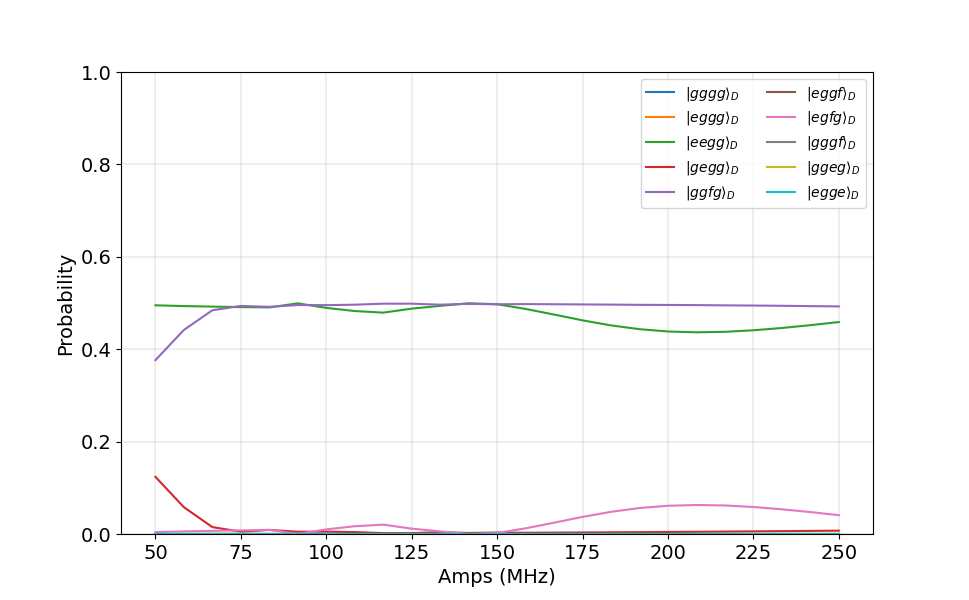

In [272]:
plt.figure()
prob_states = dict()
for state in plot_states:
    psi = qram.state(state)
    prob_states.update({state:[np.abs(psi.overlap(results_amps[i_amp]))**2 for i_amp in range(len(amps))]})

for state in plot_states:
    plt.plot(amps*1e3, prob_states[state], label=rf'$|{state}\rangle_D$')

plt.legend(fontsize=10, ncol=2)
plt.ylim(0, 1)
# plt.xlim(750, 1000)
plt.tick_params(labelsize=14)
plt.xlabel('Amps (MHz)', fontsize=14)
plt.ylabel('Probability', fontsize=14)
# plt.title(r'$\psi_0=|$'+psi0_name+r'$\rangle$')
# plt.title('QRAM state evolution in memory access operation')
plt.grid(linewidth=0.3)
plt.show()